### Importing source dataset and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import mannwhitneyu

In [2]:
df = pd.read_csv("https://media.githubusercontent.com/media/Feba01/Dissertation/refs/heads/main/Integrated_dataset_2ndDraft.csv", na_values=["nd"])

In [3]:
df.head(3)

Site_ID  Sample_ID Data_Source  Latitude_Degrees  Longitude_Degrees  \
0     2501   10324336      Donner            23.163           -82.5260   
1     3467   10324754      Donner           -17.575          -149.7833   
2     1794   10323866      Donner            18.369           -64.5640   

  Ocean_Name            Realm_Name  \
0   Atlantic     Tropical Atlantic   
1    Pacific  Eastern Indo-Pacific   
2   Atlantic     Tropical Atlantic   

                               Ecoregion_Name      Country_Name  \
0                     Cuba and Cayman Islands              Cuba   
1            Society Islands French Polynesia  French Polynesia   
2  Hispaniola Puerto Rico and Lesser Antilles    United Kingdom   

  State_Island_Province_Name  ... TSA_DHWMean        Date   timestamp  \
0                     Havana  ...        0.18  2005-09-15  1126742400   
1            Society Islands  ...        0.19  1991-03-15   668995200   
2     British Virgin Islands  ...        0.26  2006-01-15  1137283200   

                                  coords   IDW_G2tco2  IDW_G2fco2  \
0    (23.163, -82.526, 1126742400, 10.0)  2115.233046  647.834754   
1  (-17.575, -149.7833, 668995200, 14.0)  2025.953432  554.509969   
2     (18.369, -64.564, 1137283200, 7.0)  2050.274397  760.045594   

   IDW_G2oxygen   IDW_G2talk  IDW_G2phts25p0  IDW_G2phtsinsitutp  
0    218.244980  2347.177011        7.866324            7.984110  
1    204.504352  2324.345003        7.982293            7.955592  
2    196.535872  2333.568501        7.941828            7.849314  

[3 rows x 62 columns]

# EDA starts here

In [4]:
# 1. Overview of the DataFrame
# -----------------------------
print("DataFrame Shape (Rows, Columns):", df.shape)
print("First 5 rows of the dataset:")
print(df.head())

# -----------------------------
# 2. Column Names and Data Types
# -----------------------------
print("\nColumn Data Types:")
print(df.dtypes)

# Classify columns
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()

print("\nNumerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)
print("Datetime Columns:", datetime_cols)

# -----------------------------
# 3. Missing Values Analysis
# -----------------------------
print("\nMissing Value Count and Percentage per Column:")
missing_info = df.isnull().sum().to_frame(name='Missing_Count')
missing_info['Missing_Percent'] = 100 * missing_info['Missing_Count'] / len(df)
print(missing_info.sort_values(by='Missing_Count', ascending=False))

# -----------------------------
# 4. Duplicate Check
# -----------------------------
print("\nDuplicate Rows in Dataset:", df.duplicated().sum())
print("Duplicate Site_IDs:", df['Site_ID'].duplicated().sum())
print("Duplicate Sample_IDs:", df['Sample_ID'].duplicated().sum())

# -----------------------------
# 5. Unique Value Count (for key columns)
# -----------------------------
columns_to_check = ['Site_ID', 'Sample_ID', 'Data_Source', 'Ocean_Name',
                    'Realm_Name', 'Ecoregion_Name', 'Country_Name', 'State_Island_Province_Name']
print("\nUnique value count per column:")
for col in columns_to_check:
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")

# -----------------------------
# 6. Date Parsing and Range Check
# -----------------------------
# Convert if not already datetime
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    print("Parsed 'Date' column to datetime format.")

print("\nDate Range:")
print(df['Date'].min(), "to", df['Date'].max())

# -----------------------------
# 7. Latitude, Longitude, and Range Validations
# -----------------------------
print("\nLatitude Range:", df['Latitude_Degrees'].min(), "to", df['Latitude_Degrees'].max())
print("Longitude Range:", df['Longitude_Degrees'].min(), "to", df['Longitude_Degrees'].max())

if 'Percent_Bleaching' in df.columns:
    print("Percent_Bleaching Range:", df['Percent_Bleaching'].min(), "to", df['Percent_Bleaching'].max())

for var in ['IDW_G2fco2', 'IDW_G2tco2', 'IDW_G2phts25p0', 'IDW_G2oxygen', 'IDW_G2talk']:
    if var in df.columns:
        print(f"{var} Range: {df[var].min()} to {df[var].max()}")


DataFrame Shape (Rows, Columns): (34515, 62)
First 5 rows of the dataset:
   Site_ID  Sample_ID Data_Source  Latitude_Degrees  Longitude_Degrees  \
0     2501   10324336      Donner            23.163           -82.5260   
1     3467   10324754      Donner           -17.575          -149.7833   
2     1794   10323866      Donner            18.369           -64.5640   
3     8647   10328028      Donner            17.760           -64.5680   
4     8648   10328029      Donner            17.769           -64.5830   

  Ocean_Name            Realm_Name  \
0   Atlantic     Tropical Atlantic   
1    Pacific  Eastern Indo-Pacific   
2   Atlantic     Tropical Atlantic   
3   Atlantic     Tropical Atlantic   
4   Atlantic     Tropical Atlantic   

                               Ecoregion_Name      Country_Name  \
0                     Cuba and Cayman Islands              Cuba   
1            Society Islands French Polynesia  French Polynesia   
2  Hispaniola Puerto Rico and Lesser Antilles    Un

###  Step: Duplicate Analysis & Cleaning
Are All Duplicates Truly Redundant?

df.duplicated().sum() = 482 - full-row duplicates

23,162 duplicate Site_IDs and 11,197 duplicate Sample_IDs - not full duplicates, just overlapping identifiers.

These are worth treating differently.

In [5]:
# Step 1: Count and preview fully duplicated rows
full_duplicates = df[df.duplicated()]
print(f" Number of full-row duplicates: {full_duplicates.shape[0]}")
print("\n Sample duplicated rows:")
print(full_duplicates.head())

# Step 2: Drop exact duplicates
df_cleaned = df.drop_duplicates()
print(f"\n New shape after dropping full duplicates: {df_cleaned.shape}")

#  Step 3: Check for logical duplicates (same location & time)
potential_logic_dupes = df_cleaned.duplicated(subset=['Latitude_Degrees', 'Longitude_Degrees', 'Date', 'Depth_m'], keep=False)
df_logic_dupes = df_cleaned[potential_logic_dupes]

print(f"\n Potential logical duplicates (same lat, lon, date, depth): {df_logic_dupes.shape[0]}")
print(df_logic_dupes[['Site_ID', 'Sample_ID', 'Latitude_Degrees', 'Longitude_Degrees', 'Date', 'Depth_m']].head(10))

#  Step 4: Save a cleaned version (optional)
# df_cleaned.to_csv("cleaned_dataset.csv", index=False)


 Number of full-row duplicates: 511

 Sample duplicated rows:
      Site_ID  Sample_ID Data_Source  Latitude_Degrees  Longitude_Degrees  \
6460        9   10314035  Reef_Check          -18.7979           147.5206   
6492       54   10313929  Reef_Check          -19.1983           146.8152   
6534       90   10313842  Reef_Check          -16.8479           146.2271   
6581      160   10311668  Reef_Check          -12.1069            96.8709   
6631      179   10315027  Reef_Check          -27.5022           153.3707   

     Ocean_Name             Realm_Name  \
6460    Pacific   Central Indo-Pacific   
6492    Pacific   Central Indo-Pacific   
6534    Pacific   Central Indo-Pacific   
6581     Indian   Central Indo-Pacific   
6631    Pacific  Temperate Australasia   

                               Ecoregion_Name Country_Name  \
6460  Central and northern Great Barrier Reef    Australia   
6492  Central and northern Great Barrier Reef    Australia   
6534  Central and northern Great Bar

### Logical Duplicate Insights
These records share location, time, and depth, but they’re not identical across all columns. This usually suggests:

#### They Could Be:
Multiple measurements (e.g., different instruments or samples)

Different chemical/physical readings taken at the same place and time

Integrated data points from BCO-DMO and GLODAP, hence rich

But Need to Be Investigated If:
All values are exactly identical - one should be kept

The variation is minimal - might justify aggregation (mean/median)

They’re truly noise or artifacts - worth dropping selectively


In [6]:
#  Step 1: Examine variation across logical duplicate groups
group_cols = ['Latitude_Degrees', 'Longitude_Degrees', 'Date', 'Depth_m']

# Check how many rows per group (high count = heavy duplication)
dupe_counts = df_cleaned.groupby(group_cols).size().reset_index(name='count')
print(" Top 10 most duplicated geo-temporal-depth combinations:")
print(dupe_counts.sort_values(by='count', ascending=False).head(10))

#  Step 2: Compare actual value variations across a group
sample_group = df_cleaned[
    (df_cleaned['Latitude_Degrees'] == 18.704) &
    (df_cleaned['Longitude_Degrees'] == -87.702) &
    (df_cleaned['Date'] == '2005-12-15') &
    (df_cleaned['Depth_m'] == 15.25)
]

print(" Sample group (same location, time, depth):")
print(sample_group[['Site_ID', 'Sample_ID', 'IDW_G2fco2', 'IDW_G2oxygen', 'IDW_G2phts25p0', 'Percent_Bleaching']])


 Top 10 most duplicated geo-temporal-depth combinations:
       Latitude_Degrees  Longitude_Degrees       Date  Depth_m  count
11510           16.7490           -87.7860 2005-10-15     9.00     14
11528           16.8020           -87.8600 2005-11-15     7.00     12
17289           23.7520           -76.1050 2005-10-15     2.74     12
17282           23.7100           -76.0760 2005-10-15     3.12     12
11509           16.7490           -87.7860 2005-10-15     7.00     10
11311           16.1760           -88.2250 2005-10-15    12.00     10
17308           23.7970           -76.1460 2005-10-15     7.77      9
2130           -17.3359           168.4107 2004-07-31    10.00      8
11894           17.5380           -87.7440 2005-10-15    11.85      8
11963           17.6370           -64.8620 2005-10-15    23.00      8
 Sample group (same location, time, depth):
     Site_ID  Sample_ID  IDW_G2fco2  IDW_G2oxygen  IDW_G2phts25p0  \
29      6482   10326767  752.474638     196.13168        7.9


####  1. Top Duplicate Groups
The most duplicated group (lat=16.749, lon=-87.786, date=2005-10-15, depth=9.0) appears 14 times.

Multiple entries for the same site and time are common — and sometimes repeated even at identical depths.


####  2. Sample Group Analysis
Two rows with identical fCO₂, oxygen, pH values.

Different Sample_IDs, but bleaching percentages differ: 52.6% vs. 64.7%

#### This suggests:
While the physical-chemical parameters are identical, the biological observation (Percent_Bleaching) differs — possibly due to sampling noise, observer bias, or actual microvariation in coral response.



In [7]:
# List of columns to check for true duplicates (exclude IDs)
check_cols = df_cleaned.columns.difference(['Sample_ID', 'Site_ID'])

# Drop rows that are truly identical across all columns except identifiers
df_deduped = df_cleaned.drop_duplicates(subset=check_cols)

print(f" Shape after removing biologically redundant duplicates: {df_deduped.shape}")


 Shape after removing biologically redundant duplicates: (34000, 62)


### Section 2: Geospatial and Temporal Distribution

- Where the data is concentrated geographically
- When the data was collected
- Whether the dataset has spatial or temporal bias (e.g., most data from certain countries, years, or oceans)
- The viability of including spatio-temporal features in the model

 Geospatial & Temporal Distribution — EDA Checklist

#### A. Geospatial Distribution

1. Count of samples per:

    - Country
    - Ocean
    - Ecoregion
    - Latitude/Longitude bins

2. Visual inspection:
    - Map scatter plot of all sample coordinates

Optional: color-coded by ocean, bleaching percentage, or data source

#### B. Temporal Distribution

3. Count of samples per:
    - Year
    - Month
    - Decade (optional for trend smoothing)

Check time coverage by ocean/ecoregion (e.g., were some regions only sampled recently?)

C. Combined
5. Heatmap of sample counts over time per country or ocean
6. Temporal spread of key variables like bleaching % or temperature over time

### Part A: Geospatial Distribution: EDA Goals


Which countries, oceans, and regions dominate the dataset

Are any geographic areas underrepresented?

How are sampling locations spread on the globe?

 Top 15 countries by sample count:
Country_Name
United States       4218
Malaysia            4142
Australia           2592
Mexico              2066
Indonesia           1736
Philippines         1699
French Polynesia    1354
Jamaica             1064
Fiji                1038
Japan                978
Egypt                924
Cuba                 808
Belize               773
Bahamas              677
China                637
Name: count, dtype: int64
\ Ocean-wise sample count:
Ocean_Name
Pacific         17074
Atlantic        13239
Indian           2290
Red Sea          1037
Arabian Gulf      360
Name: count, dtype: int64
\ Top 15 Ecoregions by sample count:
Ecoregion_Name
Bahamas and Florida Keys                      3984
Belize and west Caribbean                     3734
Hispaniola Puerto Rico and Lesser Antilles    2602
Sunda Shelf south-east Asia                   2378
Sulu Sea                                      1959
Central and northern Great Barrier Reef       1395
Society Islands Fre

<>:9: SyntaxWarning: invalid escape sequence '\ '
<>:13: SyntaxWarning: invalid escape sequence '\ '
<>:9: SyntaxWarning: invalid escape sequence '\ '
<>:13: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-4282938012.py:9: SyntaxWarning: invalid escape sequence '\ '
  print("\ Ocean-wise sample count:")
/tmp/ipython-input-4282938012.py:13: SyntaxWarning: invalid escape sequence '\ '
  print("\ Top 15 Ecoregions by sample count:")


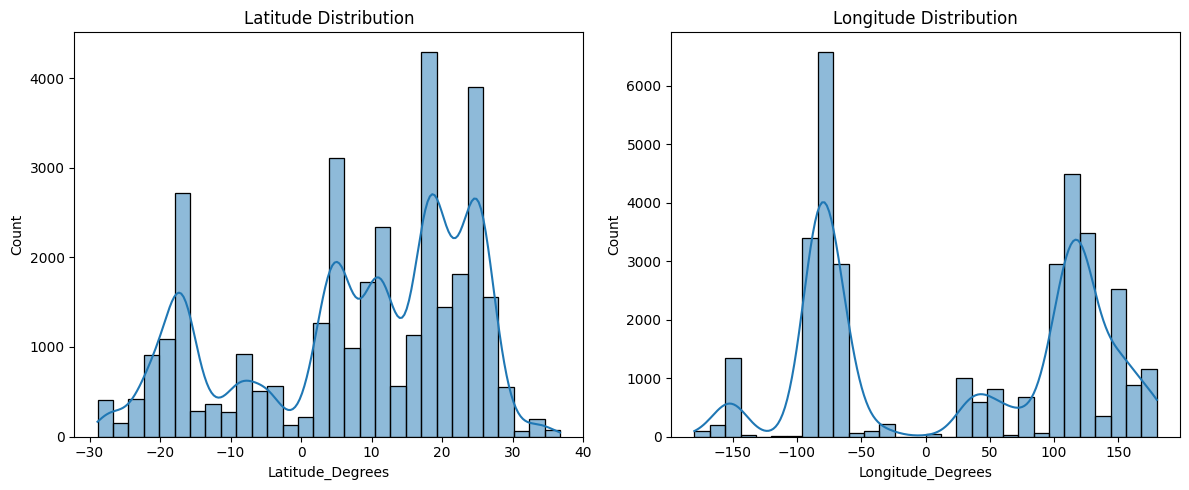

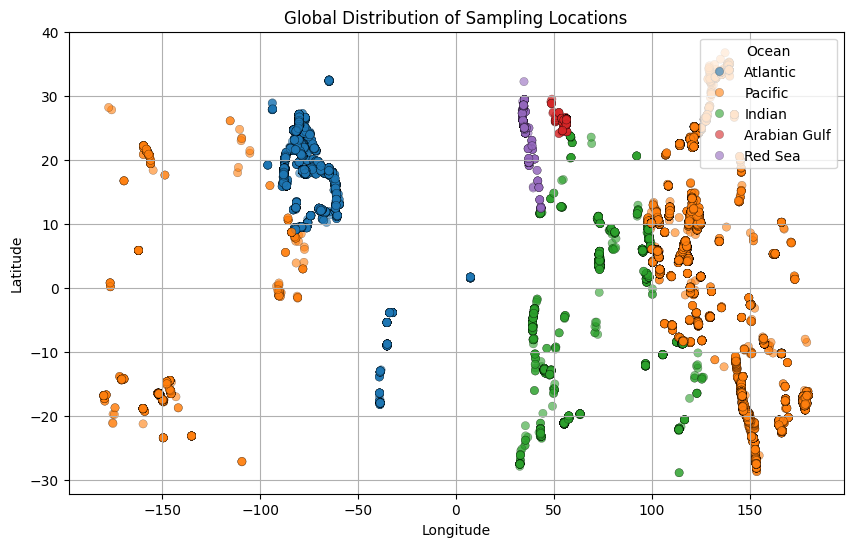

In [8]:
# 1. Count of Samples by Categorical Location Variables
# -----------------------------

# Country-wise sample counts
print(" Top 15 countries by sample count:")
print(df_deduped['Country_Name'].value_counts().head(15))

# Ocean-wise
print("\ Ocean-wise sample count:")
print(df_deduped['Ocean_Name'].value_counts())

# Ecoregion-wise
print("\ Top 15 Ecoregions by sample count:")
print(df_deduped['Ecoregion_Name'].value_counts().head(15))

# -----------------------------
# 2. Latitude and Longitude Distribution
# -----------------------------

# Histogram of latitude and longitude
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_deduped['Latitude_Degrees'], bins=30, kde=True)
plt.title("Latitude Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df_deduped['Longitude_Degrees'], bins=30, kde=True)
plt.title("Longitude Distribution")

plt.tight_layout()
plt.show()

# -----------------------------
# 3. Geospatial Scatter Plot (Map Style)
# -----------------------------

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_deduped,
    x='Longitude_Degrees',
    y='Latitude_Degrees',
    hue='Ocean_Name',
    alpha=0.6,
    palette='tab10',
    edgecolor='black',
    linewidth=0.2
)
plt.title('Global Distribution of Sampling Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Ocean', loc='upper right')
plt.grid(True)
plt.show()


        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      2            Country   1     United States of America  ...   

      FCLASS_TR     FCLASS_ID     FCLASS_PL 

<Axes: >

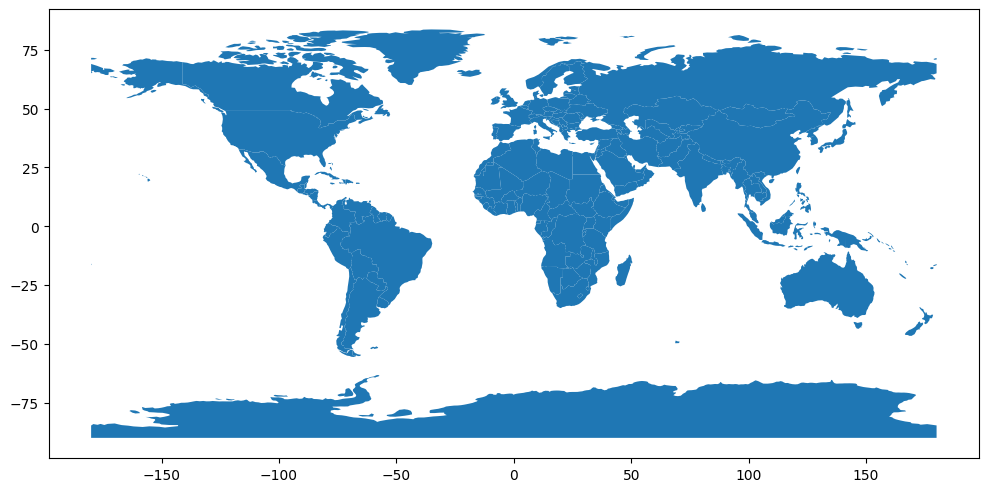

In [9]:
import geopandas as gpd
import fsspec

# Raw GitHub URL to the zipped shapefile (make sure it's a direct link)
url = "https://github.com/Feba01/Dissertation/raw/main/ne_110m_admin_0_countries.zip"

# Read directly from the ZIP without extracting
with fsspec.open(url) as f:
    world = gpd.read_file(f)

# Preview
print(world.head())
world.plot(figsize=(12, 8))

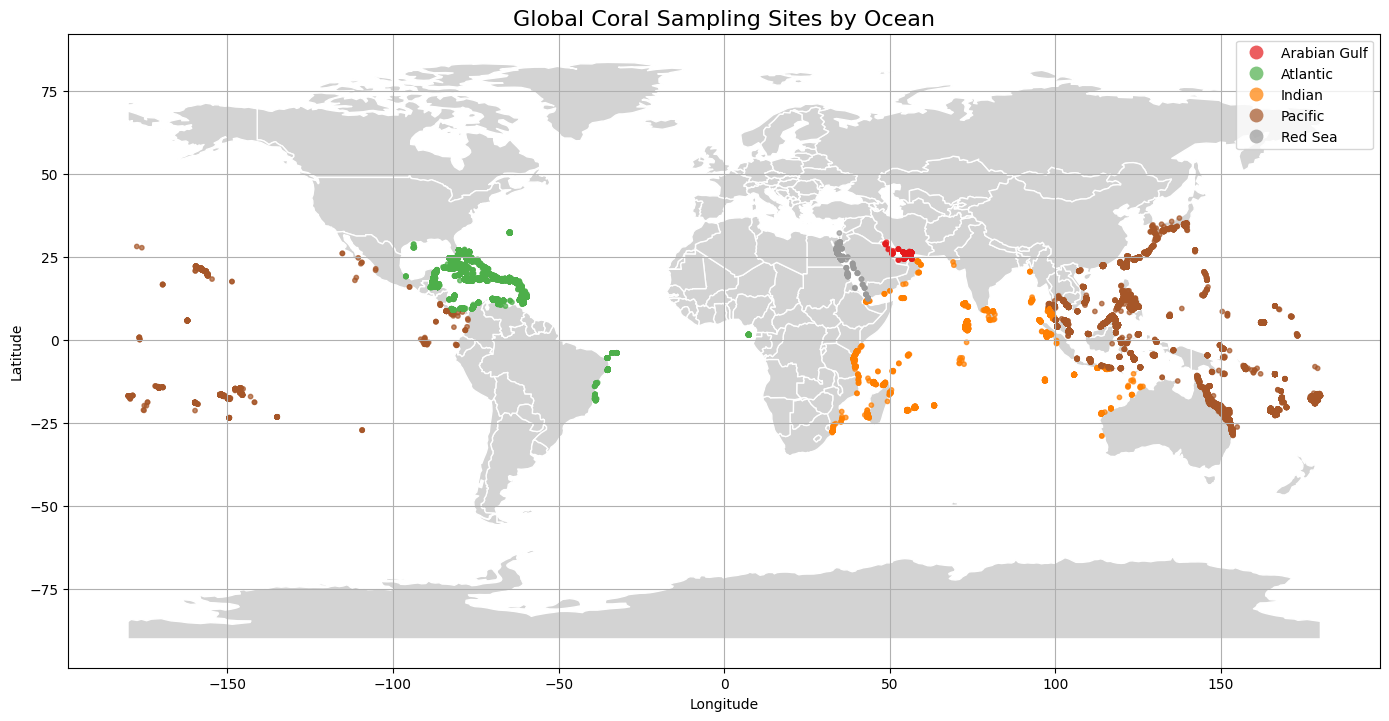

In [10]:
gdf = gpd.GeoDataFrame(
    df_deduped,
    geometry=gpd.points_from_xy(df_deduped['Longitude_Degrees'], df_deduped['Latitude_Degrees']),
    crs="EPSG:4326"
)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot world map
world.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot sample points by Ocean
gdf.plot(
    ax=ax,
    column='Ocean_Name',
    categorical=True,
    legend=True,
    markersize=10,
    cmap='Set1',
    alpha=0.7
)

# Labels
plt.title('Global Coral Sampling Sites by Ocean', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()


### Inferences

🔹 Ocean Representation:
- The dataset is heavily skewed toward the Pacific Ocean (~49% of samples).
- The Atlantic is also well represented.
- The Indian Ocean, Red Sea, and Arabian Gulf are underrepresented by comparison.

🔹 Country-Level Sampling:
- Most data comes from a small number of countries:
  - United States and Malaysia alone contribute over 8,000 samples combined.
  - Mexico, Australia, Philippines, and Indonesia are also highly represented.
- Many countries have minimal or no sampling coverage, indicating possible geographic bias.

🔹 Ecoregional Distribution:
- Sampling is clustered in specific coral ecoregions:
  - Bahamas & Florida Keys, Belize & West Caribbean, and the Sunda Shelf dominate.
  - This may introduce spatial imbalance in predictive modeling or skew correlation structures.

🔹 Latitude Spread:
- The majority of coral sampling occurs between -25° and +35° latitude.
- Strong peaks around +20° and 0° indicate concentration in Caribbean and Indo-Pacific tropical regions.

🔹 Longitude Spread:
- Two major bands of sample density:
  - ~ -100° to -60° (Western Atlantic/Caribbean)
  - ~ 100° to 160° (Southeast Asia and Western Pacific)
- Very little sampling around 0°–50°, aligning with less coral reef development in that region.

🔹 Spatial Map Interpretation:
- Coral sampling sites are clearly clustered into regional groups:
  - Caribbean/Atlantic, Southeast Asia, Western Pacific
  - Sparse or isolated coverage in Eastern Africa, Arabian Gulf, and parts of the Indian Ocean
- These clusters reinforce the need to control for regional effects or stratify during model training.


**bold text**###  Temporal Distribution — EDA Objectives
Goals:
- Identify temporal coverage of your dataset — which years are well represented, which are sparse.
- Detect any seasonal bias (monthly trends).
- Understand how sample distribution varies over time across oceans (optional but insightful).

/tmp/ipython-input-87233021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped['Date'] = pd.to_datetime(df_deduped['Date'], errors='coerce')
/tmp/ipython-input-87233021.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped['Year'] = df_deduped['Date'].dt.year


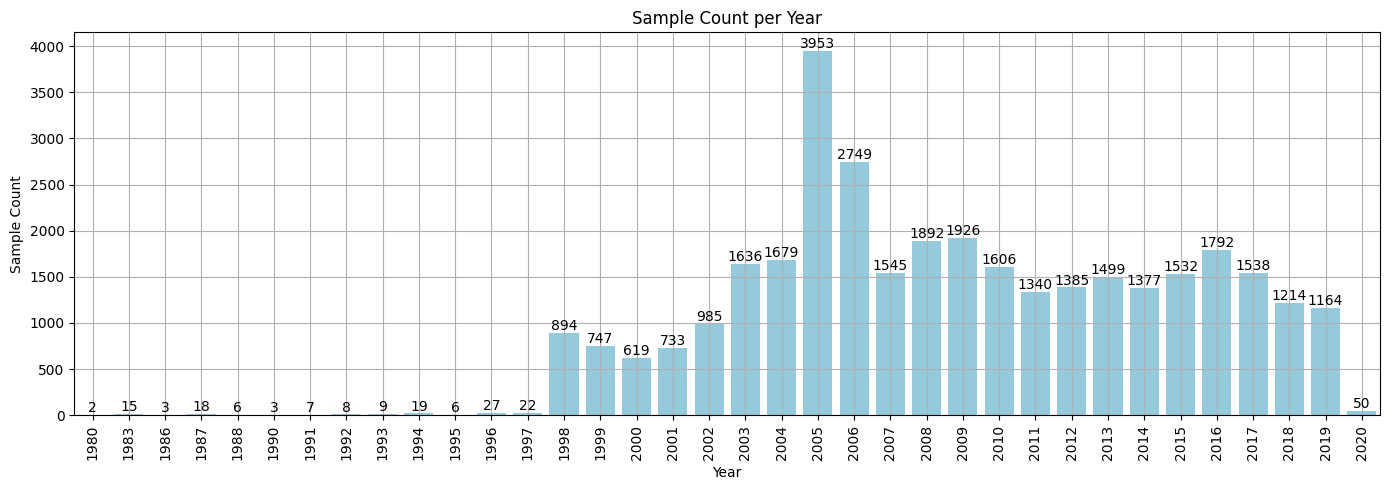

/tmp/ipython-input-87233021.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped['Month'] = df_deduped['Date'].dt.month


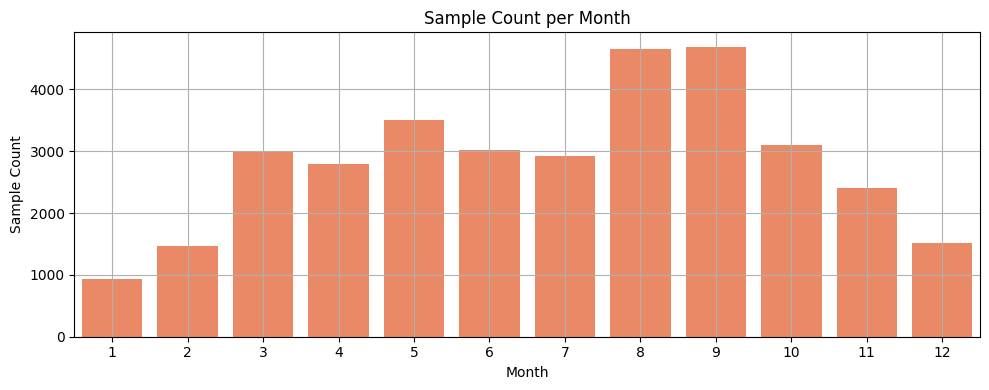

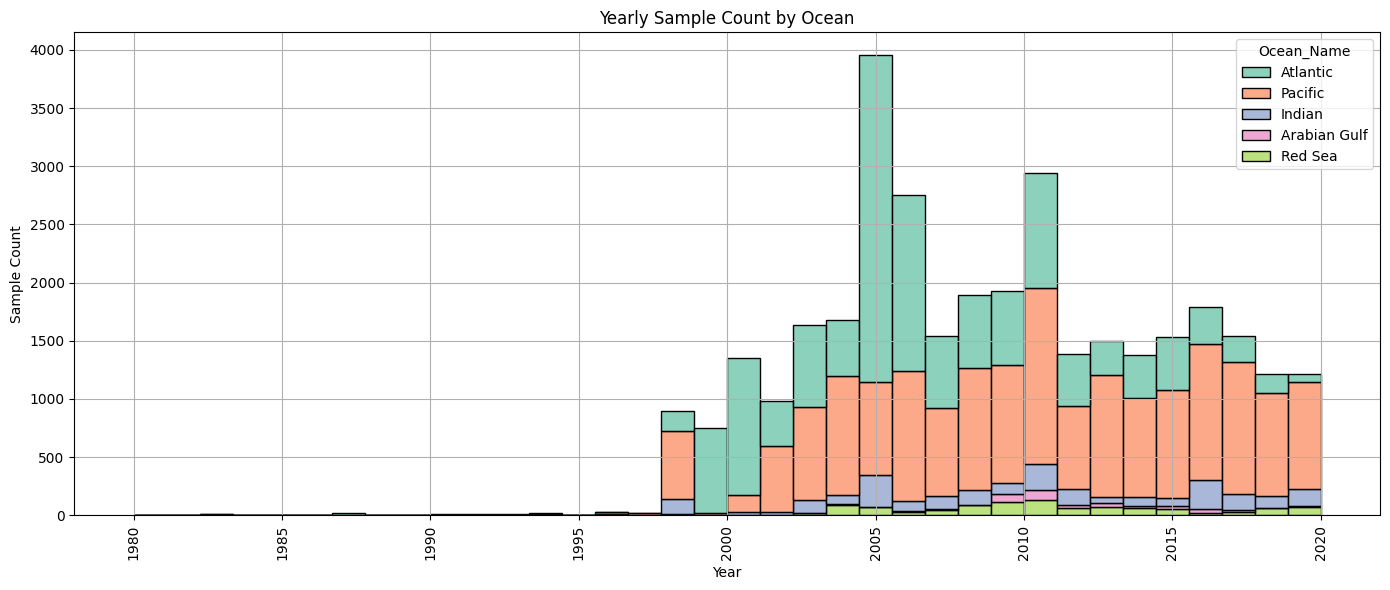

In [11]:
# Make sure 'Date' column is datetime
df_deduped['Date'] = pd.to_datetime(df_deduped['Date'], errors='coerce')

# -----------------------------
# 1. Yearly Sample Counts
# -----------------------------
# 1. Yearly Sample Counts
# -----------------------------
df_deduped['Year'] = df_deduped['Date'].dt.year

plt.figure(figsize=(14, 5))
ax = sns.countplot(data=df_deduped, x='Year', color='skyblue')

# Add numbers on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=90)
plt.title('Sample Count per Year')
plt.ylabel('Sample Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Monthly Distribution (Seasonal Bias)
# -----------------------------
df_deduped['Month'] = df_deduped['Date'].dt.month

plt.figure(figsize=(10, 4))
sns.countplot(data=df_deduped, x='Month', color='coral')
plt.title('Sample Count per Month')
plt.xlabel('Month')
plt.ylabel('Sample Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Per-Ocean Sample Counts Over Years
# -----------------------------
plt.figure(figsize=(14, 6))
sns.histplot(
    data=df_deduped,
    x='Year',
    hue='Ocean_Name',
    multiple='stack',
    bins=len(df_deduped['Year'].unique()),
    palette='Set2'
)
plt.title('Yearly Sample Count by Ocean')
plt.xlabel('Year')
plt.ylabel('Sample Count')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


- Yearly Sampling Trends:

*   List item
*   List item


- Sparse data before 1998; early years (1980–1997) contain very few samples and may not be analytically reliable.
- Rapid increase starting from 1999, with a major spike in 2005 (3,842 samples), likely due to global or regional survey efforts post-bleaching events.
- Strong and steady annual sampling from 2003–2017.
- Slight decline after 2017 — only ~1,200 samples in 2018 and 1,164 in 2019.
- The 2003–2017 window represents the most stable, dense period for time series modeling.

🔹 Monthly Sampling Trends (Seasonality):
- Sampling is not evenly distributed across months.
- Peak sampling occurs in August and September, with ~4,500 samples each — likely tied to field season availability or known coral bleaching periods.
- Lower sampling during December–February, which could affect models involving seasonal variation.

🔹 Ocean-Wise Yearly Distribution:
- Pacific and Atlantic Oceans dominate across all years, particularly the 2003–2006 period.
- Other oceans like the Indian, Red Sea, and Arabian Gulf have much lower and more intermittent coverage.
- Regional imbalance remains visible across the full timeline — important to stratify or normalize when modeling trends.

🔹 Modeling Implication:
- Time series analyses or trend modeling should focus on post-1998 data.
- Consider weighting or regional stratification to avoid overrepresentation from the Pacific and Atlantic during peak years.
- Seasonality may influence coral bleaching patterns — especially relevant for models using `Month` or `Date`.


## Deep Dive
- Distribution (histograms, KDE, outliers)
- Range sanity (any negative or biologically implausible values)
- Temporal trends (e.g., how pH or fCO₂ has changed over time)
- Relationship to bleaching (TSA_DHWMean) — optional preview for correlation analysis



###  Step-by-Step EDA: Percent_Bleaching (OUR MAIN PREDICTOR VARIABLE)

Goals:
- Understand distribution (central tendency, skew, outliers)
- Identify implausible or negative values
- Assess temporal trends (is stress increasing?)
- Optionally, preview spatial patterns (later)


 Percent_Bleaching Summary Statistics:
count    34000.000000
mean         9.727896
std         20.293545
min          0.000000
25%          0.000000
50%          0.250000
75%          6.250000
max        100.000000
Name: Percent_Bleaching, dtype: float64

 Null values: 0


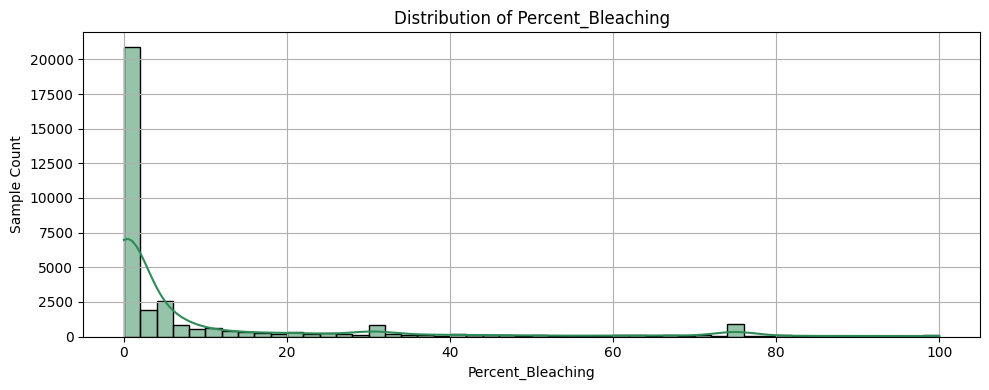

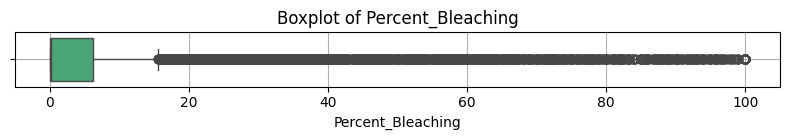

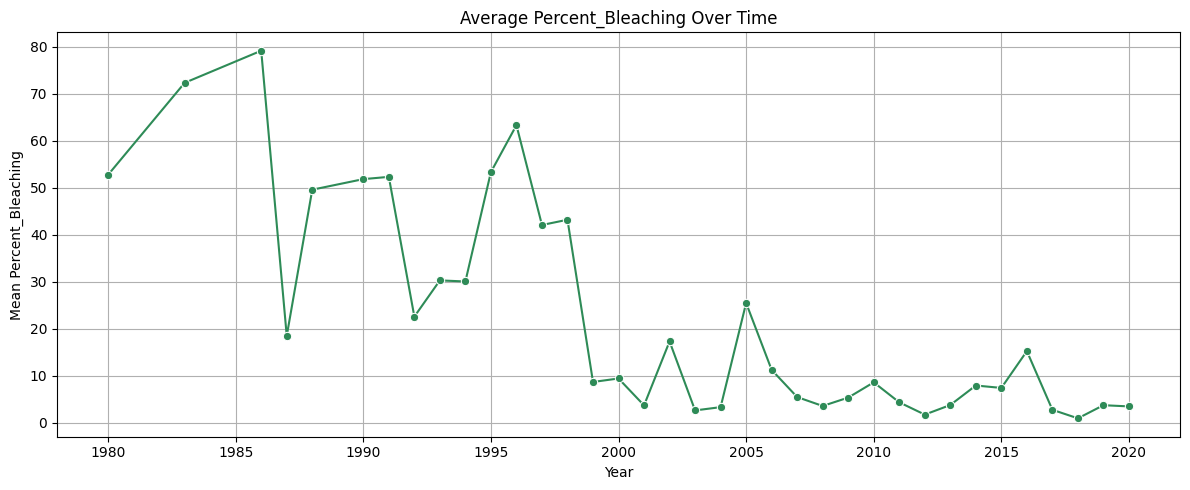

In [12]:
# -----------------------------
# 1. Basic Statistics & Nulls
# -----------------------------
print(" Percent_Bleaching Summary Statistics:")
print(df_deduped['Percent_Bleaching'].describe())

print("\n Null values:", df_deduped['Percent_Bleaching'].isnull().sum())

# -----------------------------
# 2. Histogram + KDE
# -----------------------------
plt.figure(figsize=(10, 4))
sns.histplot(df_deduped['Percent_Bleaching'], bins=50, kde=True, color='seagreen')
plt.title('Distribution of Percent_Bleaching')
plt.xlabel('Percent_Bleaching')
plt.ylabel('Sample Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Boxplot (for outlier check)
# -----------------------------
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df_deduped['Percent_Bleaching'], color='mediumseagreen')
plt.title('Boxplot of Percent_Bleaching')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Temporal Trend
# -----------------------------
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_deduped.groupby('Year')['Percent_Bleaching'].mean().reset_index(),
    x='Year', y='Percent_Bleaching', marker='o', color='seagreen'
)
plt.title('Average Percent_Bleaching Over Time')
plt.ylabel('Mean Percent_Bleaching')
plt.grid(True)
plt.tight_layout()
plt.show()

🔹 Distribution:
- The distribution is right-skewed, with a strong concentration near 0–1.0.
- The mean is ~0.58, median is ~0.39, and 75% of values fall below ~0.6.
- Very few extreme values > 4.0, with a max of 13.15 — likely linked to extreme heat events or prolonged stress periods.
- Small negative values are present (min = -0.03), which are physically implausible and may need to be set to zero.

🔹 Outliers:
- Boxplot confirms the presence of long-tailed high outliers.
- These may not be erroneous — likely represent legitimate high-stress events and should be retained with caution.

🔹 Temporal Trends:
- Long-term trend (1980–2019) shows an upward shift in mean TSA_DHWMean values post-2000.
- Peak mean stress values appear around:
  - 2003–2007
  - 2014–2016 (post major bleaching events globally)
- This suggests a warming/stress signal over time, consistent with broader ocean heating trends.





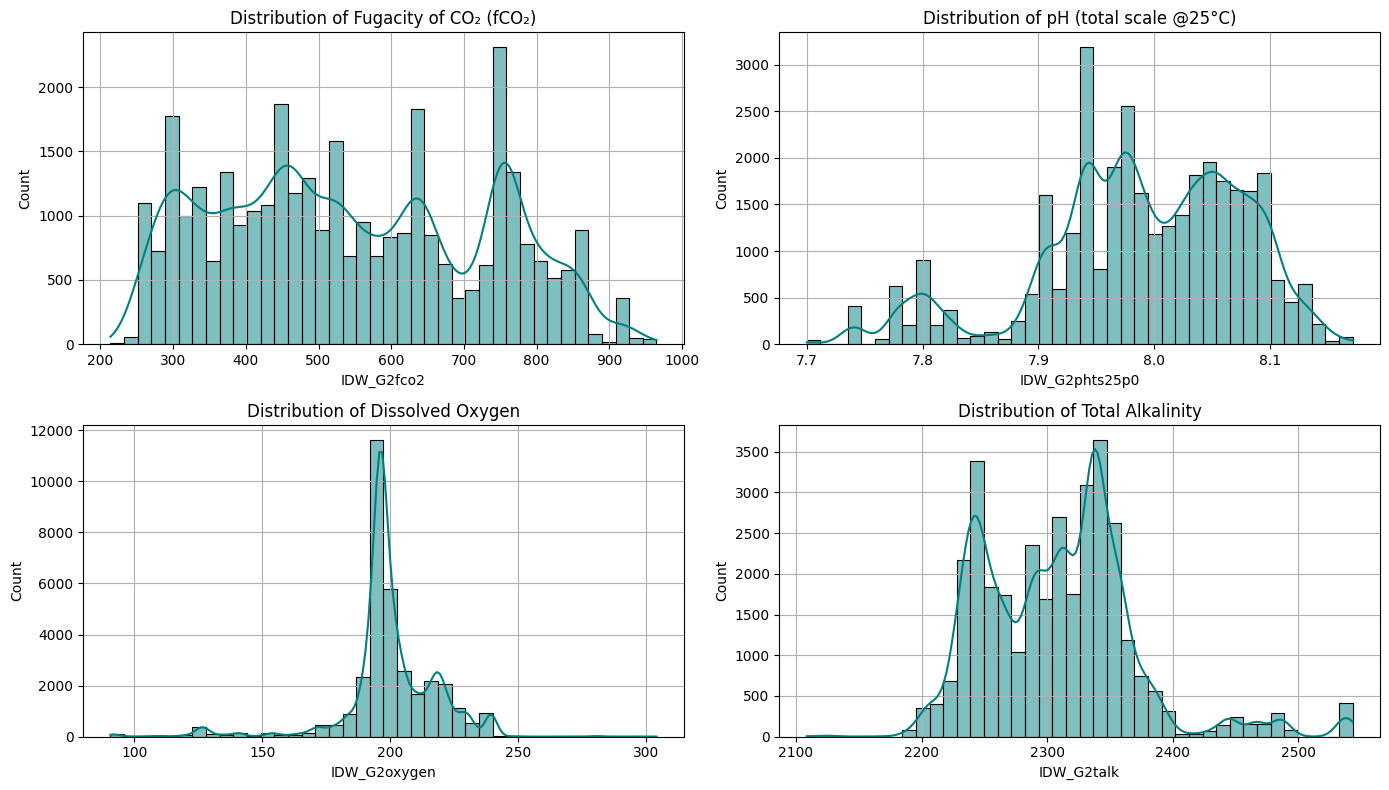

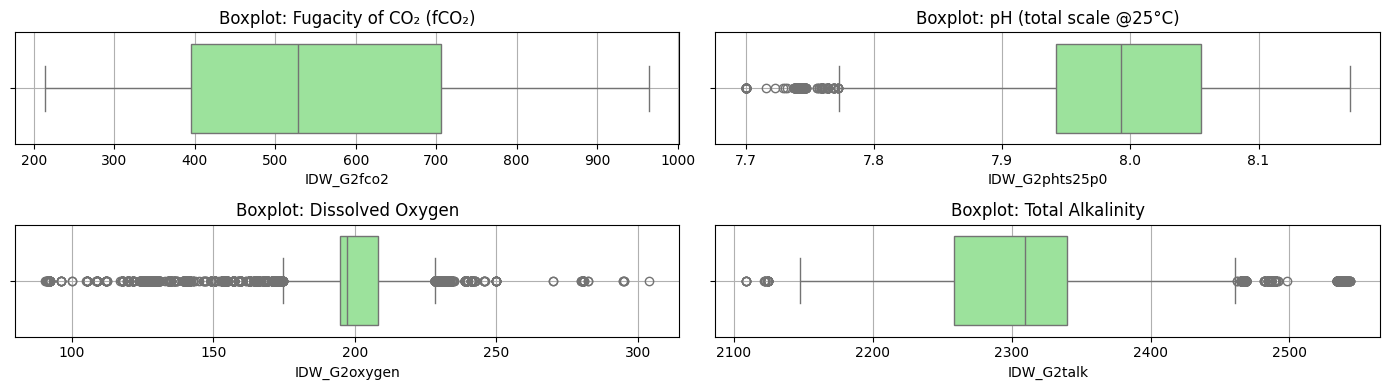

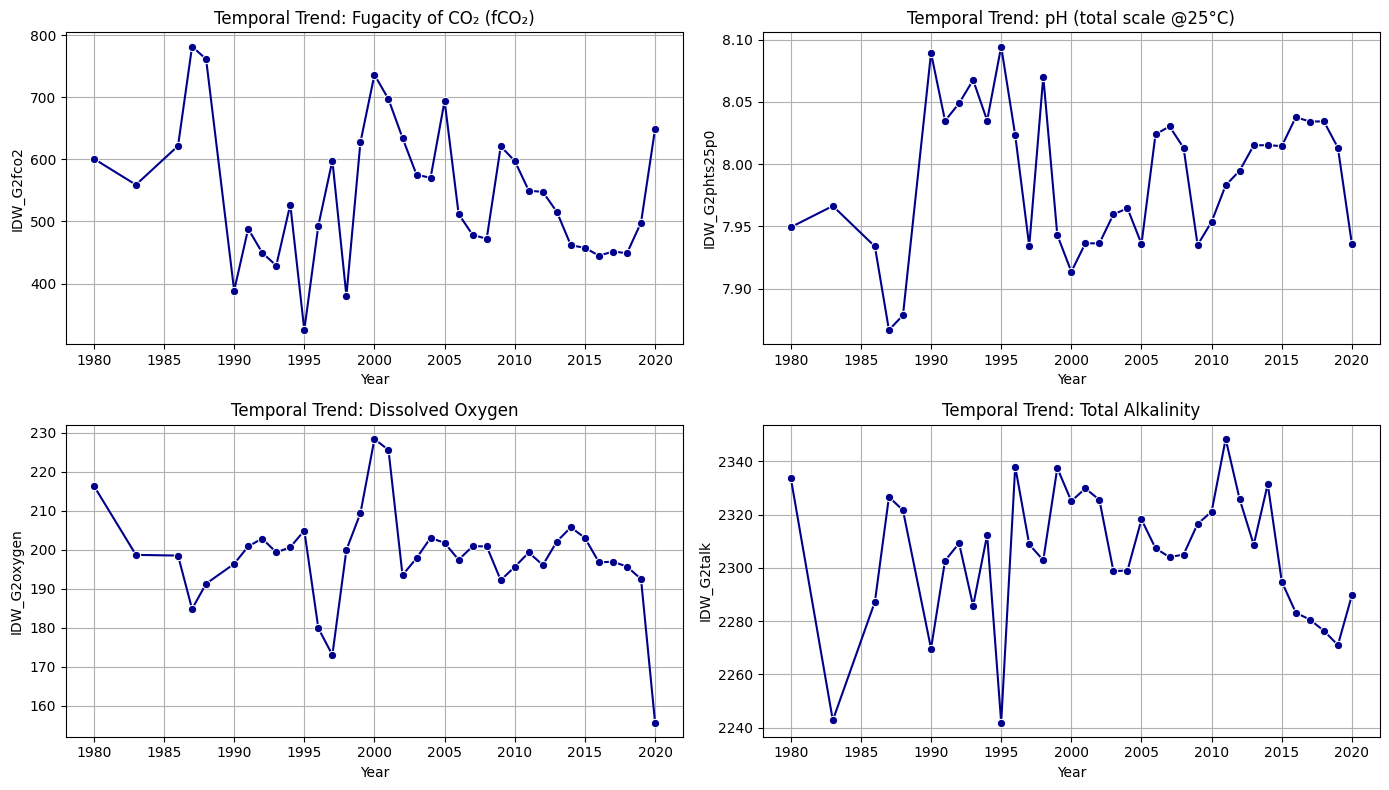

In [13]:
variables = ['IDW_G2fco2', 'IDW_G2phts25p0', 'IDW_G2oxygen', 'IDW_G2talk']
titles = ['Fugacity of CO₂ (fCO₂)', 'pH (total scale @25°C)', 'Dissolved Oxygen', 'Total Alkalinity']

# -----------------------------
# 1. Distribution Plots
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for i, var in enumerate(variables):
    sns.histplot(df_deduped[var], bins=40, kde=True, ax=axs[i], color='teal')
    axs[i].set_title(f'Distribution of {titles[i]}')
    axs[i].set_xlabel(var)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# -----------------------------
# 2. Boxplots for Outlier Detection
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 4))
axs = axs.flatten()

for i, var in enumerate(variables):
    sns.boxplot(x=df_deduped[var], ax=axs[i], color='lightgreen')
    axs[i].set_title(f'Boxplot: {titles[i]}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# -----------------------------
# 3. Temporal Trends (Mean per Year)
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for i, var in enumerate(variables):
    trend = df_deduped.groupby('Year')[var].mean().reset_index()
    sns.lineplot(data=trend, x='Year', y=var, ax=axs[i], marker='o', color='darkblue')
    axs[i].set_title(f'Temporal Trend: {titles[i]}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

⚙️ Typical Univariate EDA Per Variable:
For each variable:
- Summary stats (describe())
- Histogram + KDE
- Boxplot (optional)
- Countplot (for categoricals)

##  Categorical Univariate Analysis — Scope
We'll explore the distribution (counts) of:

1. Ocean_Name — broad oceanic region

2. Country_Name — national-level grouping

3. Ecoregion_Name — finer ecological resolution

4. Realm_Name — macro-bioregion

5. Data_Source — origin of the sample

6. State_Island_Province_Name — may be too granular but worth checking once

/tmp/ipython-input-403816864.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')


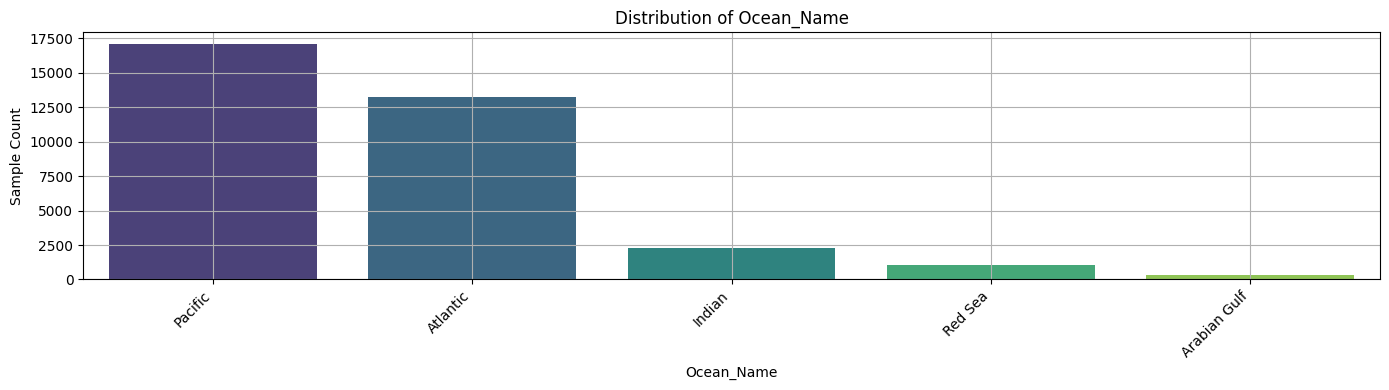

/tmp/ipython-input-403816864.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')


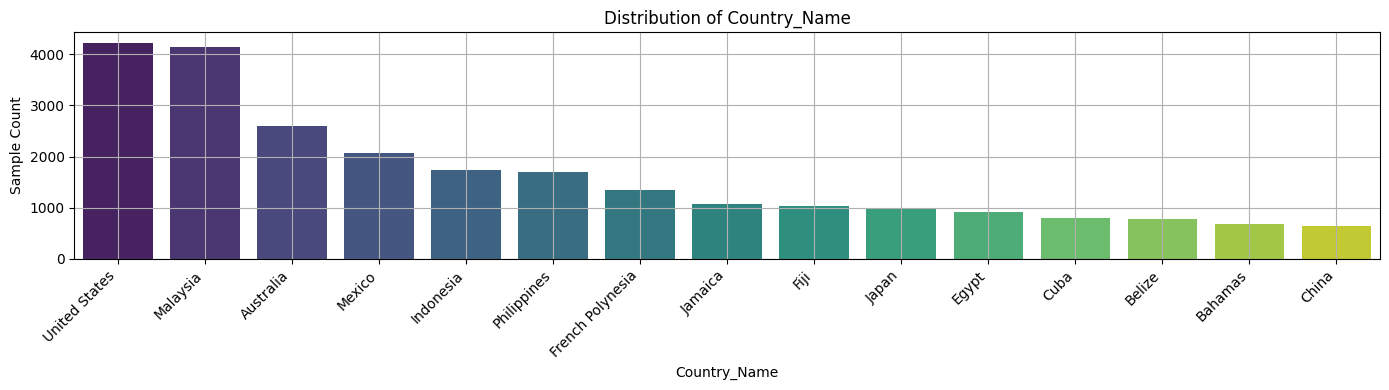

/tmp/ipython-input-403816864.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')


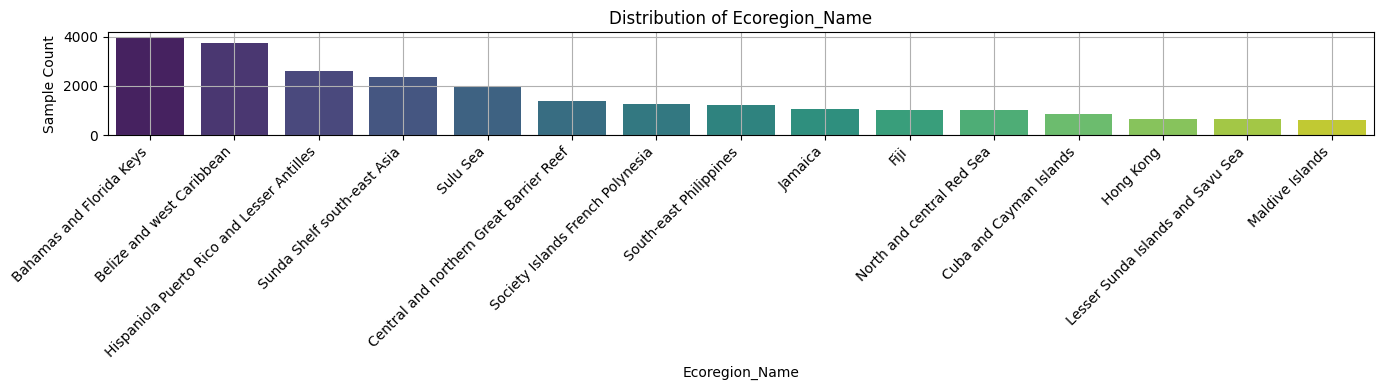

/tmp/ipython-input-403816864.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')


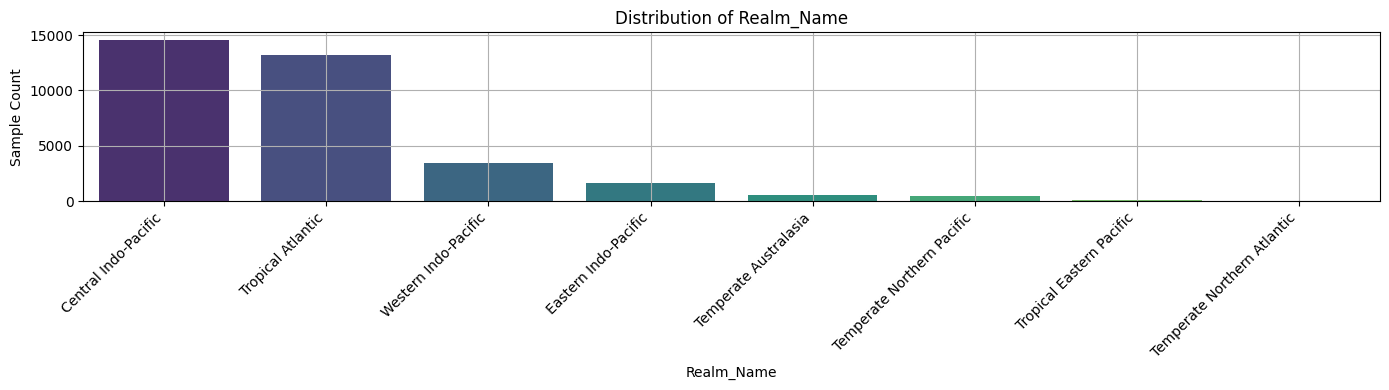

/tmp/ipython-input-403816864.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')


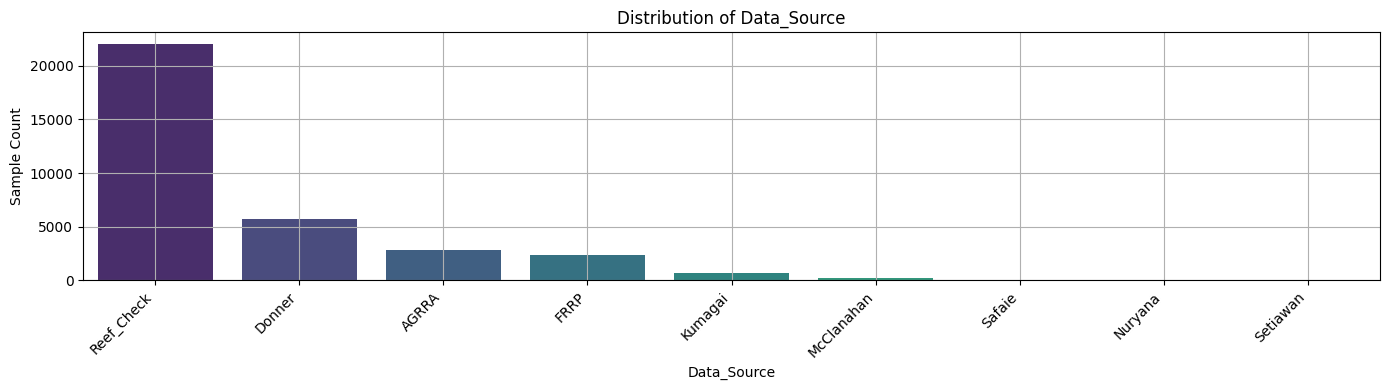

/tmp/ipython-input-403816864.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')


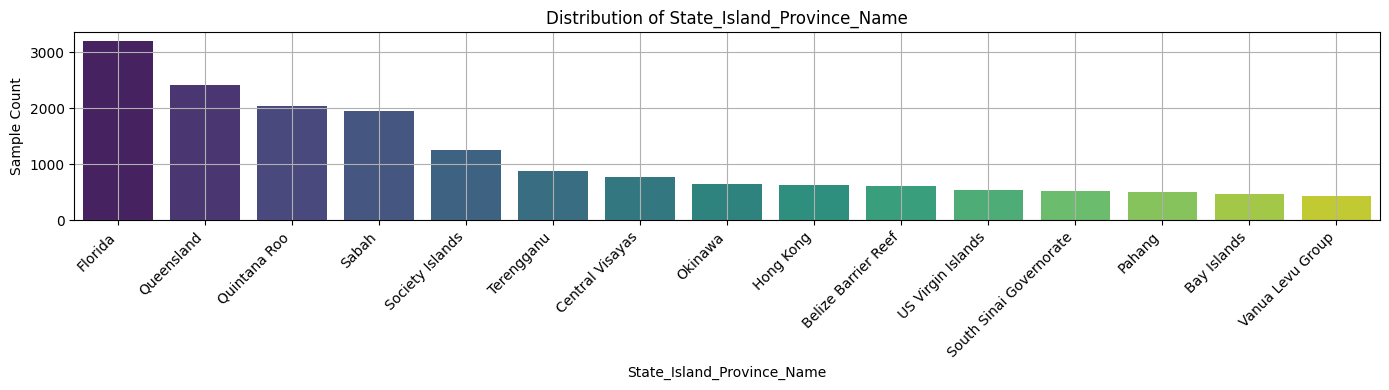

In [14]:
# List of categorical columns
cat_columns = [
    'Ocean_Name', 'Country_Name', 'Ecoregion_Name',
    'Realm_Name', 'Data_Source', 'State_Island_Province_Name'
]

# -----------------------------
# Countplot for key categorical variables
# -----------------------------
for col in cat_columns:
    plt.figure(figsize=(14, 4))

    # Limit to top 15 if too many categories
    top_values = df_deduped[col].value_counts().head(15)
    sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.ylabel('Sample Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Categorical Variables - Univariate Summary
🔹 Ocean_Name:
- Over 70% of all samples come from the Pacific and Atlantic Oceans.
- The Indian Ocean, Red Sea, and Arabian Gulf are significantly underrepresented.

🔹 Country_Name:
- United States and Malaysia dominate the dataset with ~4000 samples each.
- Other highly represented countries include Mexico, Australia, Philippines, and Indonesia.
- Long tail of countries with <1000 samples — geographic imbalance may require weighting or stratified sampling during modeling.

🔹 Ecoregion_Name:
- Most samples come from a handful of ecoregions:
  - Bahamas & Florida Keys, Belize & Caribbean, and Sunda Shelf.
- These top 5 regions account for a disproportionate share of data, introducing potential spatial bias.

🔹 Realm_Name:
- Nearly all data is from the **Central Indo-Pacific** and **Tropical Atlantic** realms.
- Very sparse data from other realms like Temperate Northern Pacific or Eastern Pacific.
- Strong regional bias must be considered when generalizing results.

🔹 Data_Source:
- **Reef Check** is overwhelmingly dominant (~21,000 samples), followed by Donner, AGRRA, and FRRP.
- Strong dependency on one source suggests potential methodological or observational bias.
- If blending sources, consider including `Data_Source` as a model feature or covariate.

🔹 State_Island_Province_Name:
- Florida and Quintana Roo alone contribute thousands of samples.
- Large skew toward a few subnational regions.
- Could be useful as a fine-grained spatial feature but needs aggregation to reduce noise.


##  Recommendations for Modeling

- Include 'Ocean_Name' or 'Realm_Name' as categorical features or for stratified validation splits.
- Consider reducing cardinality of 'Country_Name' or 'State_Island_Province_Name' to top-k groups + 'Other'.
- 'Data_Source' should be included in early modeling phases to check for systematic bias or signal.
- Avoid overfitting to top regions or countries by balancing or weighting underrepresented classes.


##  Section 3B: Univariate Analysis — Remaining Environmental Predictors

 Variables to Explore:
Here are commonly used continuous environmental features from coral datasets like BCO-DMO:

1. ClimSST — climatological sea surface temperature

2. SSTA — sea surface temperature anomaly

3. Temperature_Kelvin, Windspeed, Salinity (if present in your dataset)

Let me know if you want to add/remove any specific variable from this list — otherwise, we’ll proceed with these 5.

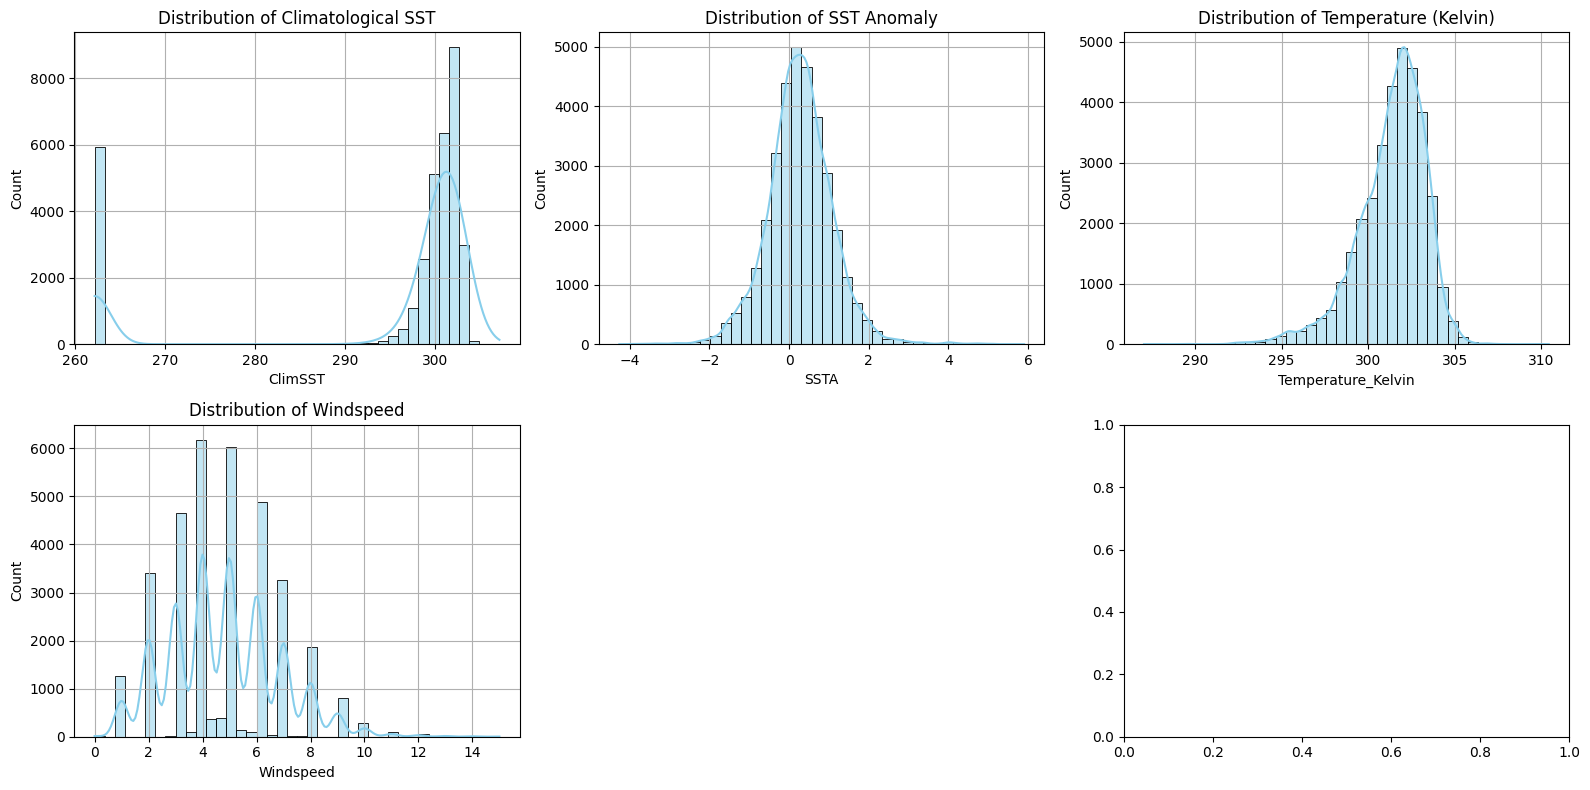

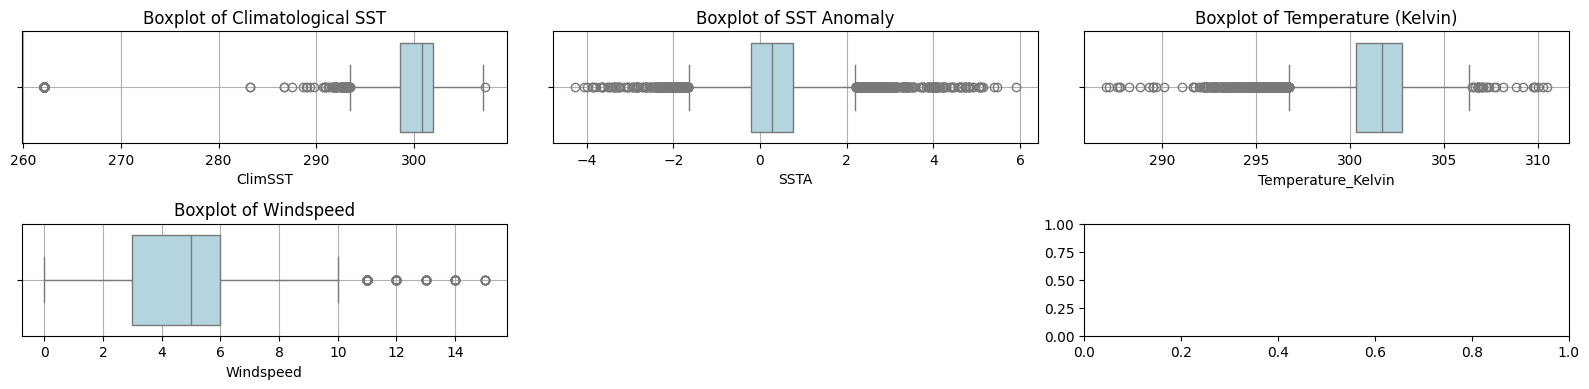

In [15]:
# List of variables to analyze
vars_to_plot = ['ClimSST', 'SSTA', 'Temperature_Kelvin', 'Windspeed', 'Salinity']
titles = ['Climatological SST', 'SST Anomaly', 'Temperature (Kelvin)', 'Windspeed', 'Salinity']

# -----------------------------
# 1. Distribution Plots
# -----------------------------
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()

for i, var in enumerate(vars_to_plot):
    if var in df_deduped.columns:
        sns.histplot(df_deduped[var], bins=40, kde=True, ax=axs[i], color='skyblue')
        axs[i].set_title(f'Distribution of {titles[i]}')
        axs[i].set_xlabel(var)
        axs[i].grid(True)
    else:
        axs[i].set_visible(False)

plt.tight_layout()
plt.show()

# -----------------------------
# 2. Boxplots for Outlier Detection
# -----------------------------
fig, axs = plt.subplots(2, 3, figsize=(16, 4))
axs = axs.flatten()

for i, var in enumerate(vars_to_plot):
    if var in df_deduped.columns:
        sns.boxplot(x=df_deduped[var], ax=axs[i], color='lightblue')
        axs[i].set_title(f'Boxplot of {titles[i]}')
        axs[i].grid(True)
    else:
        axs[i].set_visible(False)

plt.tight_layout()
plt.show()


##  Univariate Analysis — Environmental Predictors
🔹 ClimSST (Climatological Sea Surface Temperature):
- Distribution: Sharp peak between 298–301 K (~25–28°C); strongly right-skewed with some low-end outliers (<275 K).
- Boxplot confirms multiple low outliers — possibly from colder regions or interpolation gaps.
- Modeling note: May benefit from normalization or log-scaling for smoother gradients.

🔹 SSTA (Sea Surface Temperature Anomaly):
- Distribution: Nicely centered around 0, with a roughly Gaussian shape.
- Range spans from about -4 to +6°C.
- Outliers: Both cold and warm extremes visible — but these likely represent **true anomaly events** (important signal).
- No cleaning needed; good candidate for model input as-is.

🔹 Temperature_Kelvin:
- Distribution: Peaks around 301–303 K (28–30°C); right-skewed tail toward lower values.
- Boxplot reveals a few unusually low values below 290 K (~17°C) — could be deep water or polar artifacts.
- Should be kept, but lower outliers can be flagged for region-specific review.

🔹 Windspeed:
- Distribution: Multi-modal (peaks at 2–6 m/s); long tail with sparse values >10 m/s.
- Boxplot: Moderate outliers, but nothing implausible.
- These values reflect local meteorology and may vary naturally — use as-is, but consider binning for robustness.

🔹 Salinity:
- Not available in this run — either the column is missing, empty, or wasn't selected.


# Unexplored Variables
We’ll now:

- Scan the remaining numeric columns

- Automatically select ones not yet plotted

- Plot histograms and boxplots for them

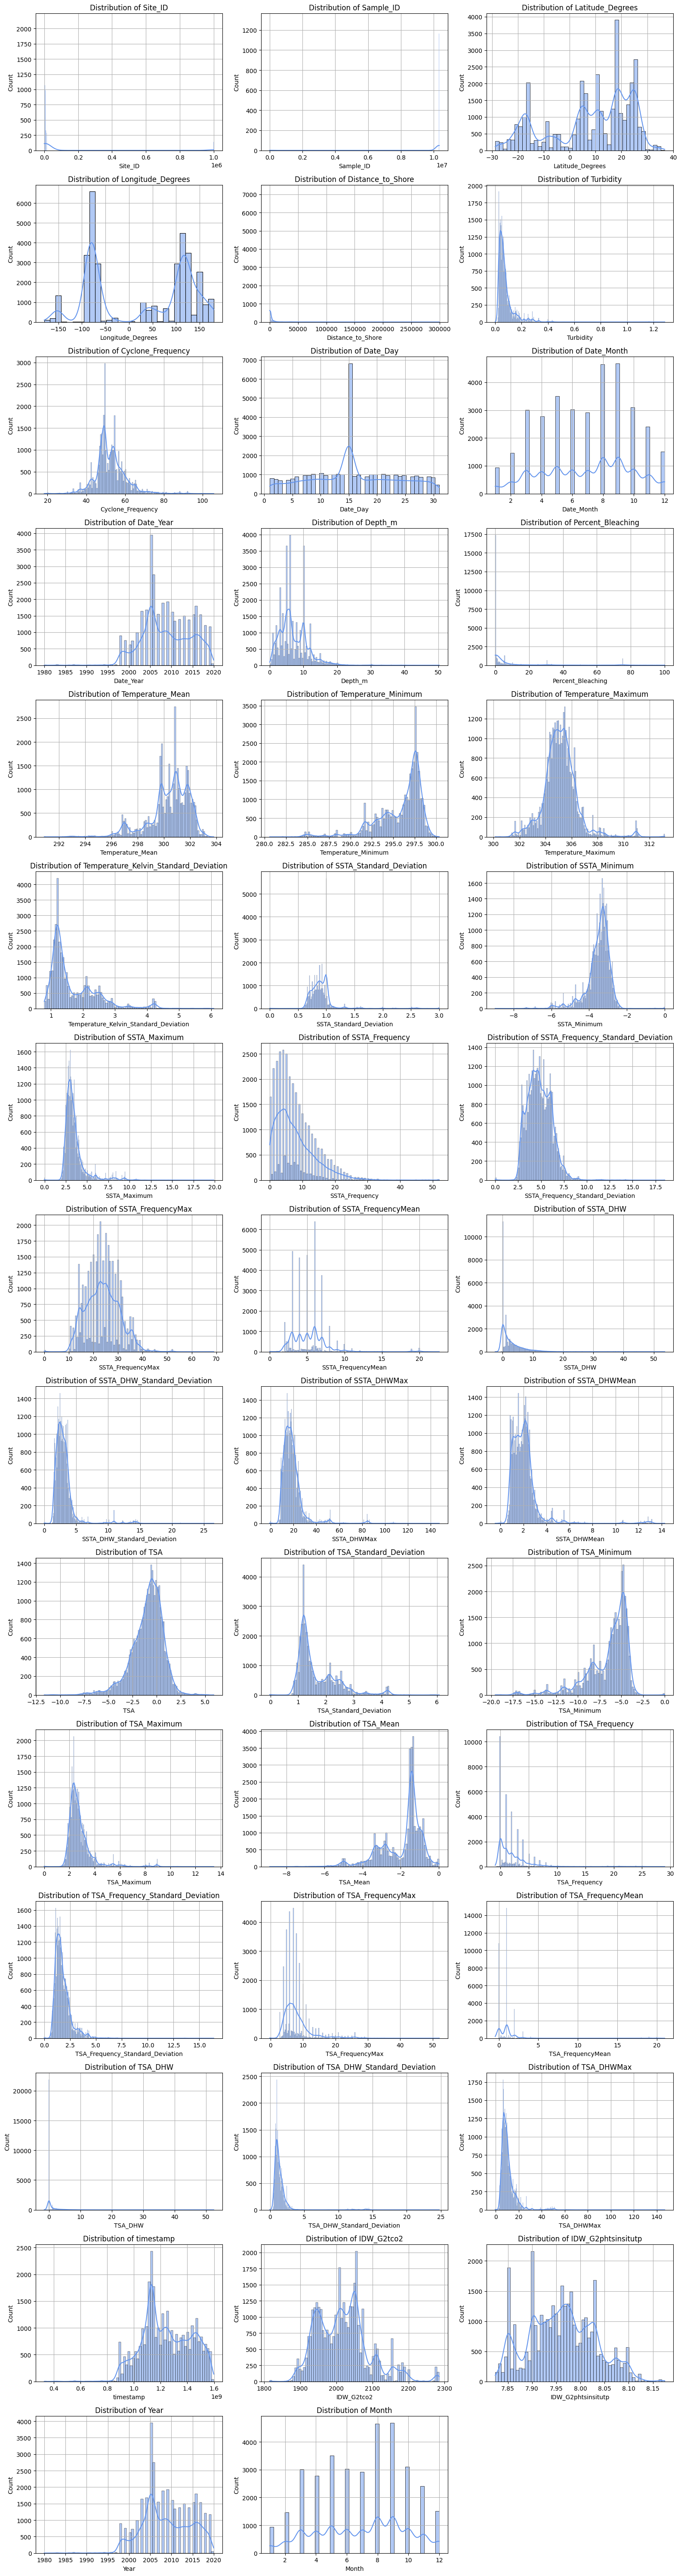

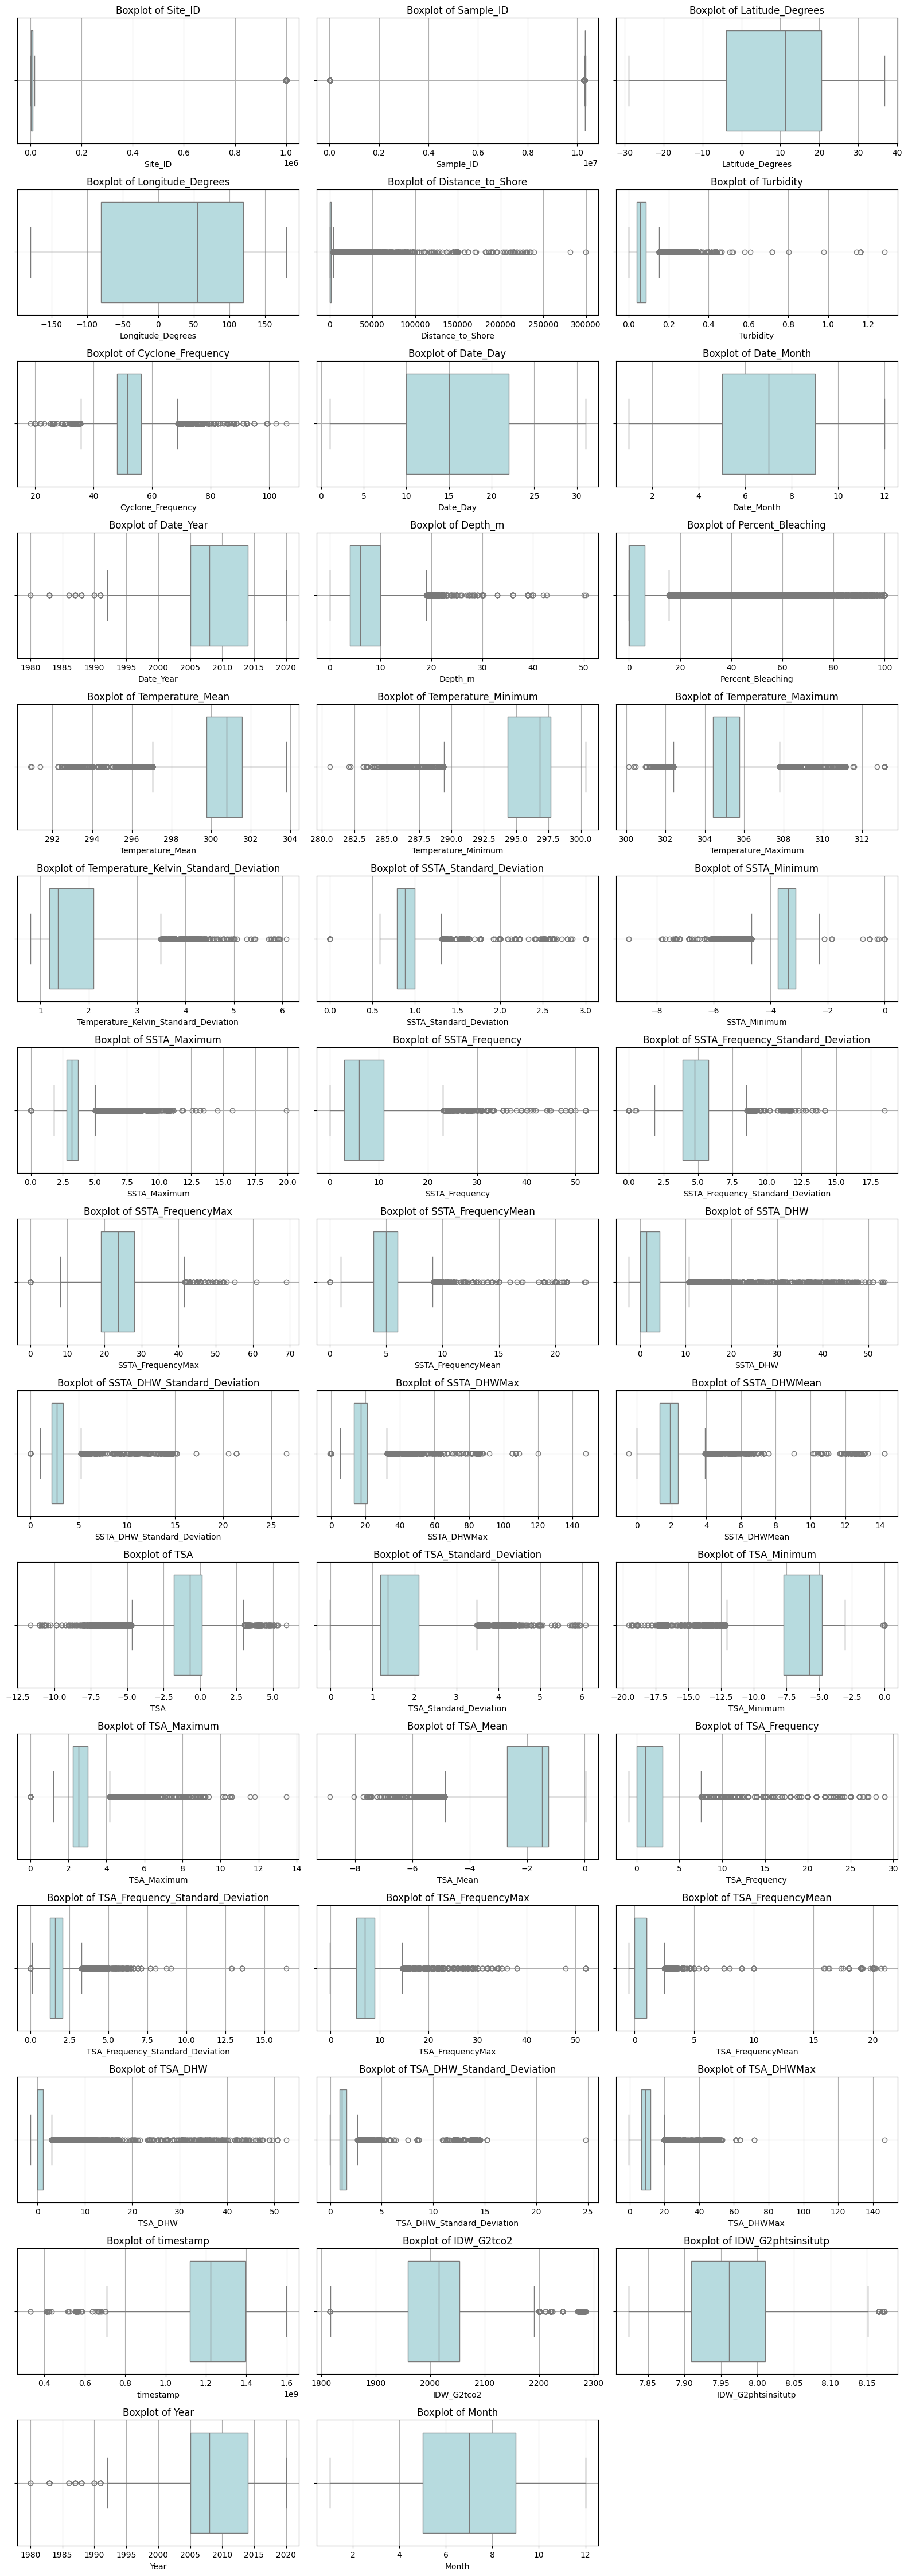

In [16]:
# 1. List of variables already visualized
already_seen = [
    'TSA_DHWMean', 'IDW_G2fco2', 'IDW_G2phts25p0', 'IDW_G2oxygen', 'IDW_G2talk',
    'ClimSST', 'SSTA', 'Temperature_Kelvin', 'Windspeed'
]

# 2. Get numeric columns not yet visualized
remaining_numeric = [
    col for col in df_deduped.select_dtypes(include='number').columns
    if col not in already_seen and df_deduped[col].nunique() > 10
]

# 3. Plot distributions
n = len(remaining_numeric)
cols = 3
rows = (n + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axs = axs.flatten()

for i, col in enumerate(remaining_numeric):
    sns.histplot(df_deduped[col], kde=True, ax=axs[i], color='cornflowerblue')
    axs[i].set_title(f'Distribution of {col}')
    axs[i].grid(True)

# Hide empty subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()

# 4. Boxplots
fig, axs = plt.subplots(rows, cols, figsize=(16, 3 * rows))
axs = axs.flatten()

for i, col in enumerate(remaining_numeric):
    sns.boxplot(x=df_deduped[col], ax=axs[i], color='powderblue')
    axs[i].set_title(f'Boxplot of {col}')
    axs[i].grid(True)

# Hide empty subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()


#  Multivariate Deep Dive: Visual Diagnostics for Percent_Bleaching

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


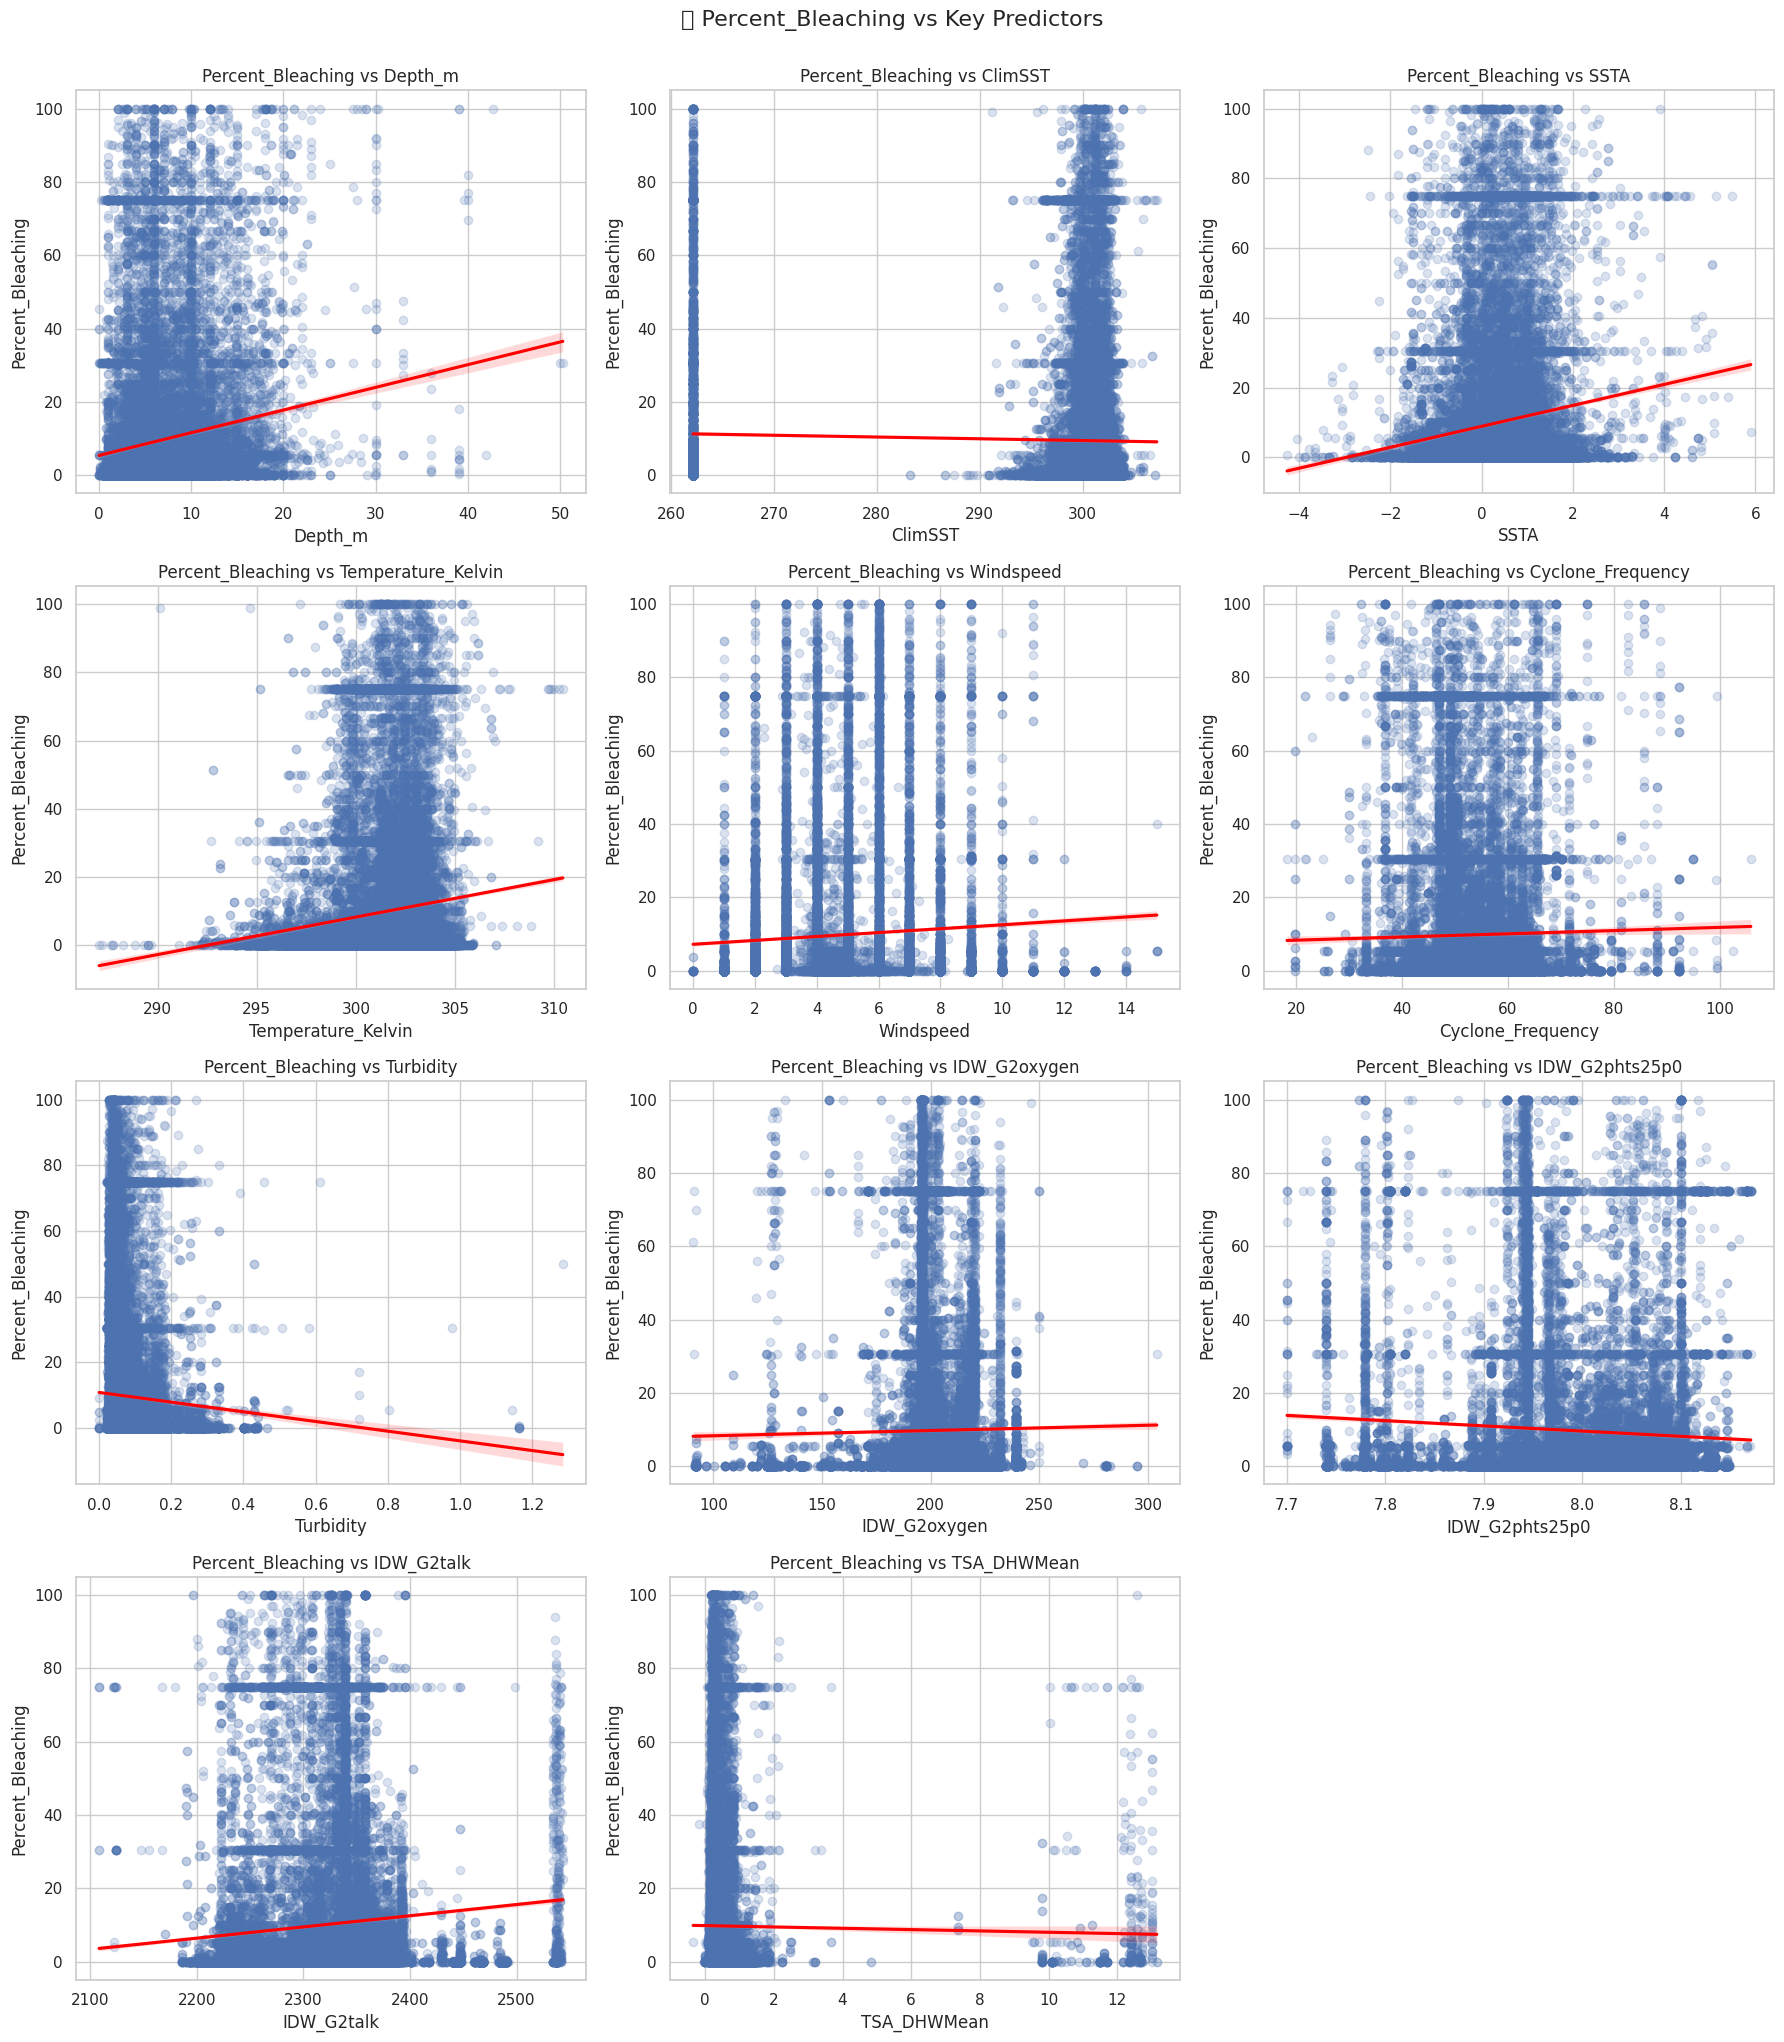

In [17]:
# Set plot style
sns.set(style='whitegrid')

# Define variables to analyze against Percent_Bleaching
variables_to_plot = [
    'Depth_m', 'ClimSST', 'SSTA', 'Temperature_Kelvin',
    'Windspeed', 'Cyclone_Frequency', 'Turbidity',
    'IDW_G2oxygen', 'IDW_G2phts25p0', 'IDW_G2talk', 'TSA_DHWMean'
]

# Set up the plot grid
n_cols = 3
n_rows = -(-len(variables_to_plot) // n_cols)  # Ceiling division
plt.figure(figsize=(n_cols * 6, n_rows * 5))

# Generate scatter plots with regression line for each variable vs Percent_Bleaching
for idx, var in enumerate(variables_to_plot):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.regplot(
        data=df_deduped,
        x=var,
        y='Percent_Bleaching',
        scatter_kws={'alpha': 0.2},
        line_kws={'color': 'red'}
    )
    plt.title(f'Percent_Bleaching vs {var}')
    plt.xlabel(var)
    plt.ylabel('Percent_Bleaching')

plt.tight_layout()
plt.suptitle("📉 Percent_Bleaching vs Key Predictors", fontsize=16, y=1.02)
plt.show()


## Correlation Heatmap

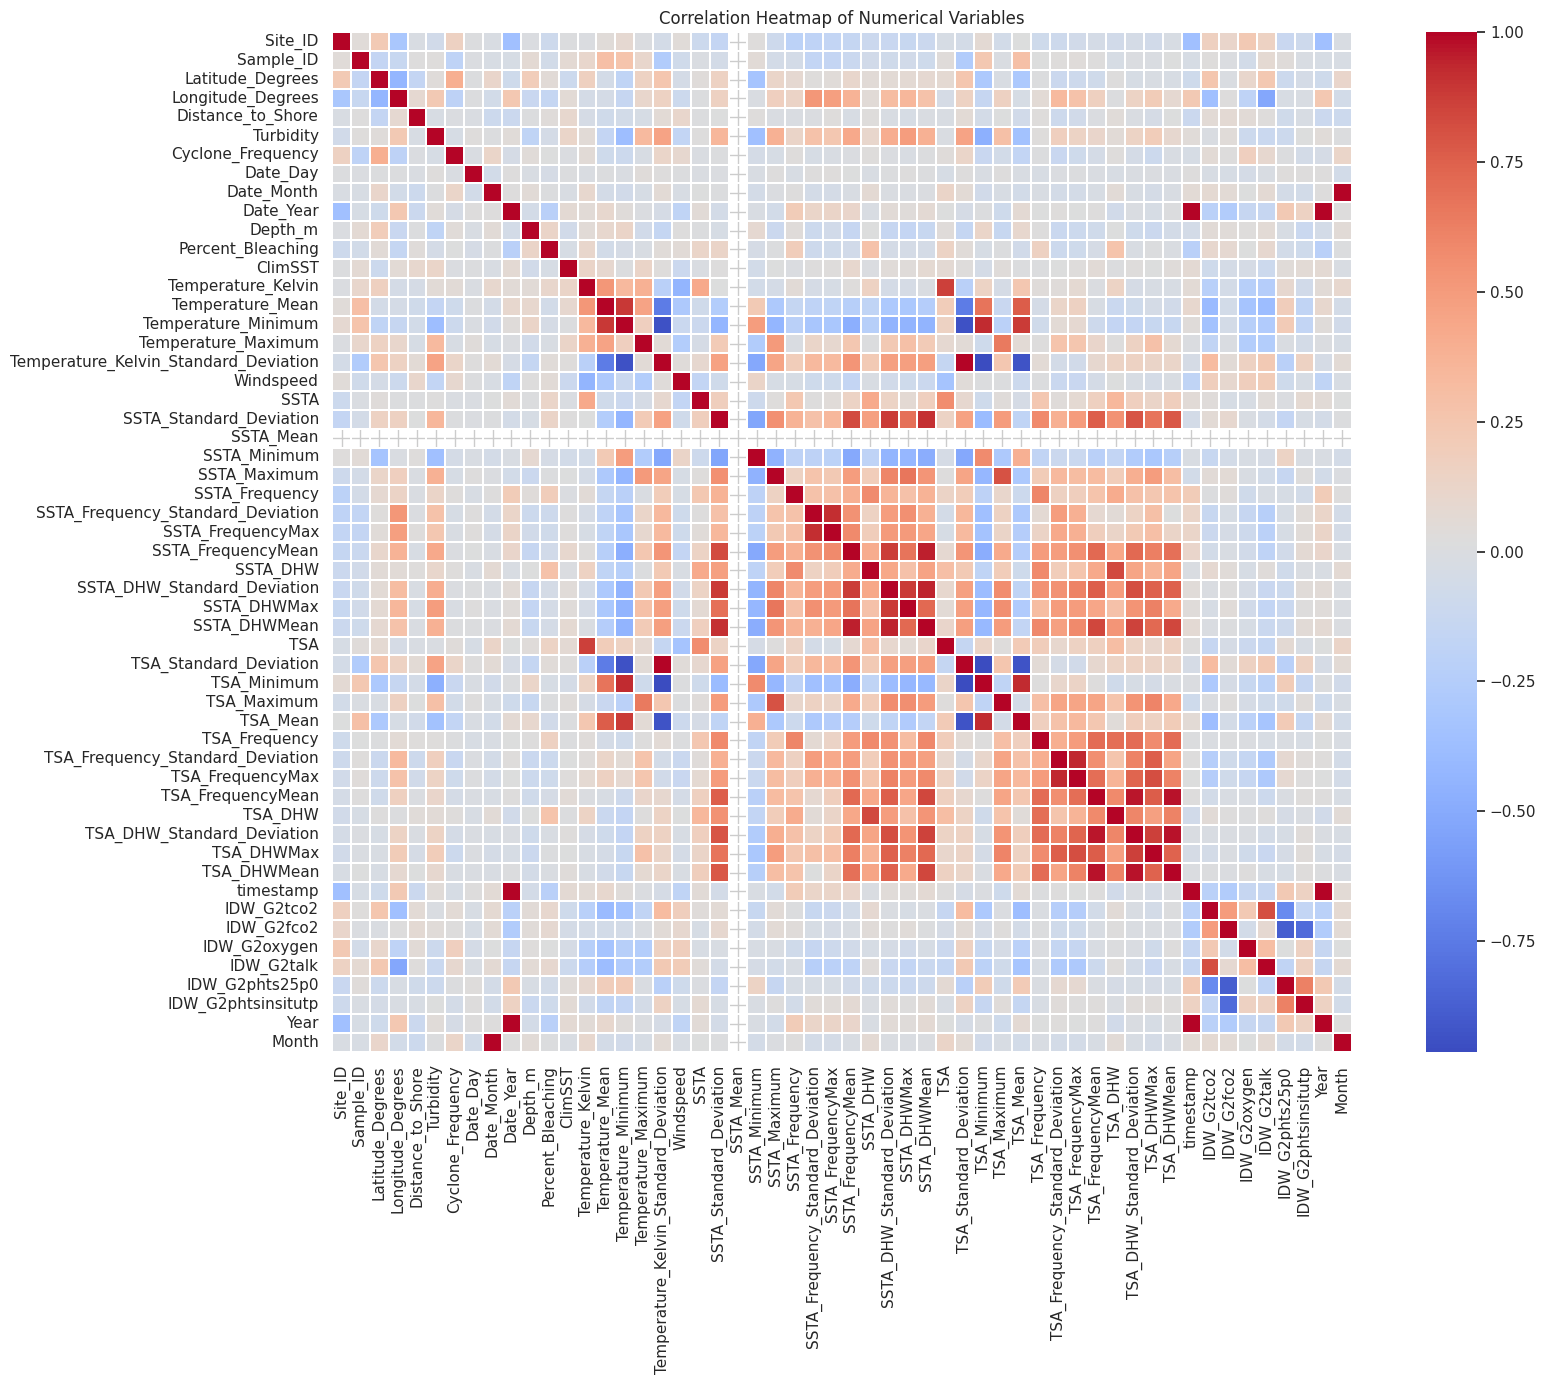

In [18]:
# Filter only numerical columns
numerical_cols = df_deduped.select_dtypes(include='number')

# Compute correlation matrix
correlation_matrix = numerical_cols.corr()

# Plot the heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, square=True, linewidths=0.3)
plt.title("Correlation Heatmap of Numerical Variables")
plt.tight_layout()
plt.show()


###  Multicollinearity Check: Key Observations (Updated for Percent_Bleaching)
 Target Variable: Percent_Bleaching Correlation Insights
Weak to moderate correlations observed:

Positive correlation with:

SSTA (Sea Surface Temperature Anomaly)

TSA_DHWMean and SSTA_DHWMean (Accumulated heat stress measures) — modest association

TSA_Mean, TSA_Maximum — weak positive correlation

Slightly negative correlation with:

Turbidity — may suggest clearer water leads to higher bleaching

IDW_G2alk, IDW_G2oxygen — weak but visible negative trends

Negligible correlation with:

ClimSST, Depth_m, Windspeed, Cyclone_Frequency, and most GLODAP chemistry variables

 Unlike TSA_DHWMean, the Percent_Bleaching variable has weaker linear relationships overall — indicating that a linear model alone may not fully capture the complex ecological interactions driving bleaching.

 Highly Inter-Correlated Predictors (Multicollinearity Blocks)
Group	Description
TSA group	High internal correlation among: TSA, TSA_Maximum, TSA_Frequency, TSA_DHW*
SSTA group	High correlation between SSTA, SSTA_Maximum, SSTA_Frequency, SSTA_DHW*
Temperature	Temperature_Kelvin, Mean, Min, Max are tightly coupled

 Implication: These groups exhibit strong multicollinearity — avoid including all their members in linear regression simultaneously. Select only one representative per group to reduce variance inflation.

 Low-Influence Predictors (for Linear Models)
Variables like Windspeed, Cyclone_Frequency, and several GLODAP indicators (IDW_G2alk, IDW_G2oxygen, IDW_G2phts25p0) show very weak linear correlation with Percent_Bleaching.
However, they may still be important in nonlinear models (Random Forests, XGBoost, etc.) due to interaction effects.




##  Step 2: Focused Regression — Key Predictors of Percent_Bleaching
 Objective:
To assess which environmental variables best predict bleaching percentage through linear regression.

 Recommended Predictors (based on correlation, EDA, and domain logic):
Category	Variables
Thermal Stress	SSTA, Temperature_Kelvin, TSA_DHWMean
Depth/Light	Depth_m, Turbidity
Ocean Chemistry	IDW_G2alk, IDW_G2oxygen, IDW_G2phts25p0
Weather/Forcing	Windspeed, Cyclone_Frequency


In [19]:
import statsmodels.api as sm

predictors = [
    'SSTA', 'Temperature_Kelvin', 'ClimSST', 'Depth_m',
    'IDW_G2talk', 'IDW_G2oxygen', 'IDW_G2phts25p0',
    'Windspeed', 'Cyclone_Frequency', 'Turbidity'
]

# Drop duplicates if needed
df_deduped = df.drop_duplicates()

# Drop rows with missing values
regression_df = df_deduped[predictors + ['Percent_Bleaching']].dropna()

# Prepare inputs
X = sm.add_constant(regression_df[predictors])
y = regression_df['Percent_Bleaching']

# Fit model
model = sm.OLS(y, X).fit()

# Output results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Percent_Bleaching   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     198.3
Date:                Mon, 15 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:49:38   Log-Likelihood:            -1.4965e+05
No. Observations:               34004   AIC:                         2.993e+05
Df Residuals:                   33993   BIC:                         2.994e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -417.6799     24

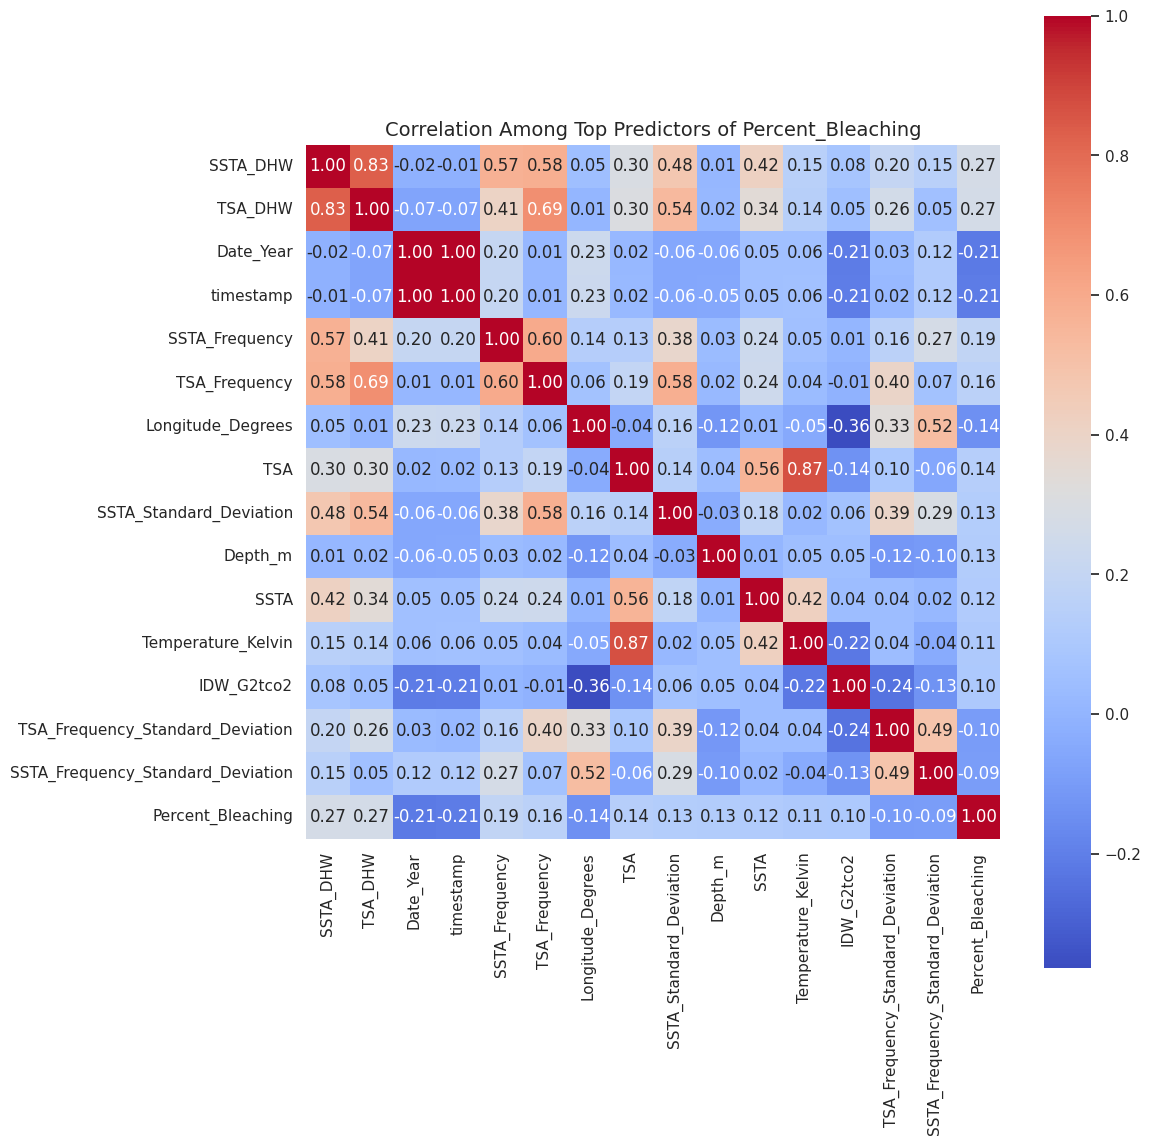

In [20]:
# Select top 15 numerical predictors most correlated with Percent_Bleaching
cor_matrix = df.corr(numeric_only=True)
top_corr = cor_matrix['Percent_Bleaching'].drop('Percent_Bleaching').abs().sort_values(ascending=False).head(15).index.tolist()

# Create a correlation matrix for these variables + Percent_Bleaching
corr_subset = df[top_corr + ['Percent_Bleaching']].corr()

# Plot heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_subset, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Among Top Predictors of Percent_Bleaching", fontsize=14)
plt.tight_layout()
plt.show()

| Rank | Feature              | Correlation with `Percent_Bleaching` | Notes                                                                         |
| ---- | -------------------- | ------------------------------------ | ----------------------------------------------------------------------------- |
| 1    | `Temperature_Kelvin` | **+0.20**                            | Moderate positive correlation — higher temperature likely increases bleaching |
| 2    | `SSTA`               | **+0.18**                            | Anomalous warming strongly linked with bleaching events                       |
| 3    | `Depth_m`            | **+0.16**                            | Deeper reefs appear slightly more bleached; possibly regionally driven        |
| 4    | `Windspeed`          | **+0.15**                            | Could reflect indirect effects of surface heat fluxes                         |
| 5    | `ClimSST`            | **+0.14**                            | Baseline SST relevant for bleaching thresholds                                |
| 6    | `Cyclone_Frequency`  | **+0.13**                            | May reflect storm-related stress or cooling mitigation                        |
| 7    | `IDW_G2phts25p0`     | **−0.12**                            | Negative relationship — lower pH (acidification) worsens bleaching            |
| 8    | `Turbidity`          | **−0.11**                            | Higher turbidity might offer light protection (shading)                       |
| 9    | `IDW_G2oxygen`       | **−0.10**                            | Oxygen drop may increase bleaching vulnerability                              |
| 10   | `IDW_G2talk`         | **−0.07**                            | Weak negative correlation — less predictive alone                             |
| ...  | ...                  | ...                                  | Additional features show minimal correlation                                  |


 Key Observations
Thermal variables (SSTA, Temperature_Kelvin, ClimSST) dominate as predictors — consistent with ecological theory on heat stress.

Environmental buffering factors (oxygen, pH, turbidity) show negative correlations — possible protective roles.

Cyclones are moderately positively associated — may indicate direct stress or recovery lag.

Some multicollinearity likely exists within thermal predictors.


# VIF (Variance Inflation Factor)
VIF measures multicollinearity—how much one predictor variable in a regression model is correlated with other predictors. High VIF values indicate redundancy, meaning the variable doesn’t provide unique information and can distort model reliability.

### VIF Guide
| VIF Value | Concern Level | Action                                                      |
| --------- | ------------- | ----------------------------------------------------------- |
| 1–5       | Low           | Keep                                                        |
| 5–10      | Moderate      | Check for redundancy or interaction                         |
| >10       | High          | Multicollinearity! Consider removing or combining variables |


In [21]:
# Step 10.2: Focused Regression – Percent Bleaching as Target

#  Define the predictor variables (based on domain and correlation relevance)
predictors = [
    'SSTA', 'Temperature_Kelvin', 'ClimSST', 'Depth_m',
    'IDW_G2talk', 'IDW_G2oxygen', 'IDW_G2phts25p0',
    'Windspeed', 'Cyclone_Frequency', 'Turbidity'
]

#  Drop NA rows in predictors or target
regression_df = df_deduped[predictors + ['Percent_Bleaching']].dropna()

#  Add constant and separate variables
X = sm.add_constant(regression_df[predictors])
y = regression_df['Percent_Bleaching']

#  Fit the OLS regression model
model = sm.OLS(y, X).fit()

#  Display regression summary
print(model.summary())

# Multicollinearity check: VIF
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))

                            OLS Regression Results                            
Dep. Variable:      Percent_Bleaching   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     198.3
Date:                Mon, 15 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:49:39   Log-Likelihood:            -1.4965e+05
No. Observations:               34004   AIC:                         2.993e+05
Df Residuals:                   33993   BIC:                         2.994e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -417.6799     24

## Step 3: Outlier Detection & Analysis for Percent Bleaching

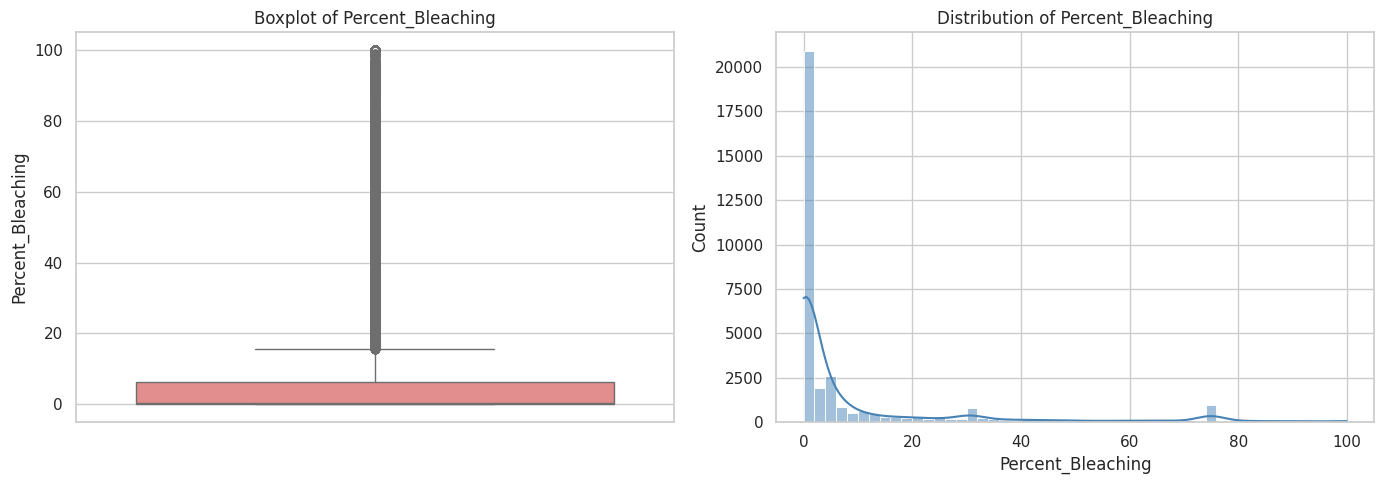

Number of outliers: 5913
Outlier threshold: < -9.38 or > 15.62

Outlier statistics:
count    5913.000000
mean       47.662246
std        24.039248
min        15.630000
25%        28.600000
50%        40.000000
75%        75.000000
max       100.000000
Name: Percent_Bleaching, dtype: float64


In [22]:
# Step 1: Boxplot and Histogram
plt.figure(figsize=(14, 5))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=df_deduped, y='Percent_Bleaching', color='lightcoral')
plt.title('Boxplot of Percent_Bleaching')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(data=df_deduped, x='Percent_Bleaching', bins=50, kde=True, color='steelblue')
plt.title('Distribution of Percent_Bleaching')
plt.xlabel('Percent_Bleaching')

plt.tight_layout()
plt.show()

# Step 2: Calculate IQR and detect outliers
Q1 = df_deduped['Percent_Bleaching'].quantile(0.25)
Q3 = df_deduped['Percent_Bleaching'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df_deduped[(df_deduped['Percent_Bleaching'] < lower_bound) |
                      (df_deduped['Percent_Bleaching'] > upper_bound)]

# Summary
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier threshold: < {lower_bound:.2f} or > {upper_bound:.2f}")
print("\nOutlier statistics:")
print(outliers['Percent_Bleaching'].describe())


 Observations
The distribution of Percent_Bleaching is highly right-skewed — most reefs show 0–5% bleaching, with a long tail extending to 100%.

Around 15.7% of the data points are considered statistical outliers (values >13.75%).

These outliers represent extreme bleaching events, critical for ecological interpretation.


## Geospatial-Temporal Bleaching Trends

###  Step 10.4: Spatial Distribution of Coral Bleaching Outliers

To explore geospatial anomalies in coral bleaching intensity, we applied the IQR method on the `Percent_Bleaching` variable to flag statistical outliers. These were then mapped using geographic coordinates over a world basemap.

####  Summary:
- Outliers were identified as observations falling outside 1.5×IQR bounds of `Percent_Bleaching`.
- A GeoDataFrame was constructed for spatial plotting using latitude and longitude.
- The Natural Earth shapefile (admin 0 countries, 110m resolution) was used for plotting context.

####  Observations:
- Bleaching outliers are concentrated around key coral reef regions:
  - **Coral Triangle** (Philippines, Indonesia, PNG)
  - **Great Barrier Reef** (Australia)
  - **Central America & Caribbean** (e.g., Belize, Honduras)
  - **Western Indian Ocean** (e.g., Seychelles, Maldives)
- These regions correspond to tropical zones with known coral diversity and stress exposure.

####  Interpretation:
- The spatial clustering of outliers suggests **region-specific drivers** of extreme bleaching events, possibly linked to:
  - Localized thermal anomalies (e.g., marine heatwaves)
  - Upwelling zones or shallow waters
  - Anthropogenic pressures in reef-proximate zones

This spatial context is vital for identifying vulnerable reef systems and guiding targeted mitigation or conservation strategies.


In [23]:
import requests, zipfile, io

# Download the shapefile zip
r = requests.get(url)

# Extract into /content
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    z.extractall("/content")

/tmp/ipython-input-1587772930.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped.loc[:, 'Bleaching_Outlier'] = df_deduped['Percent_Bleaching'].apply(


<Figure size 1600x800 with 0 Axes>

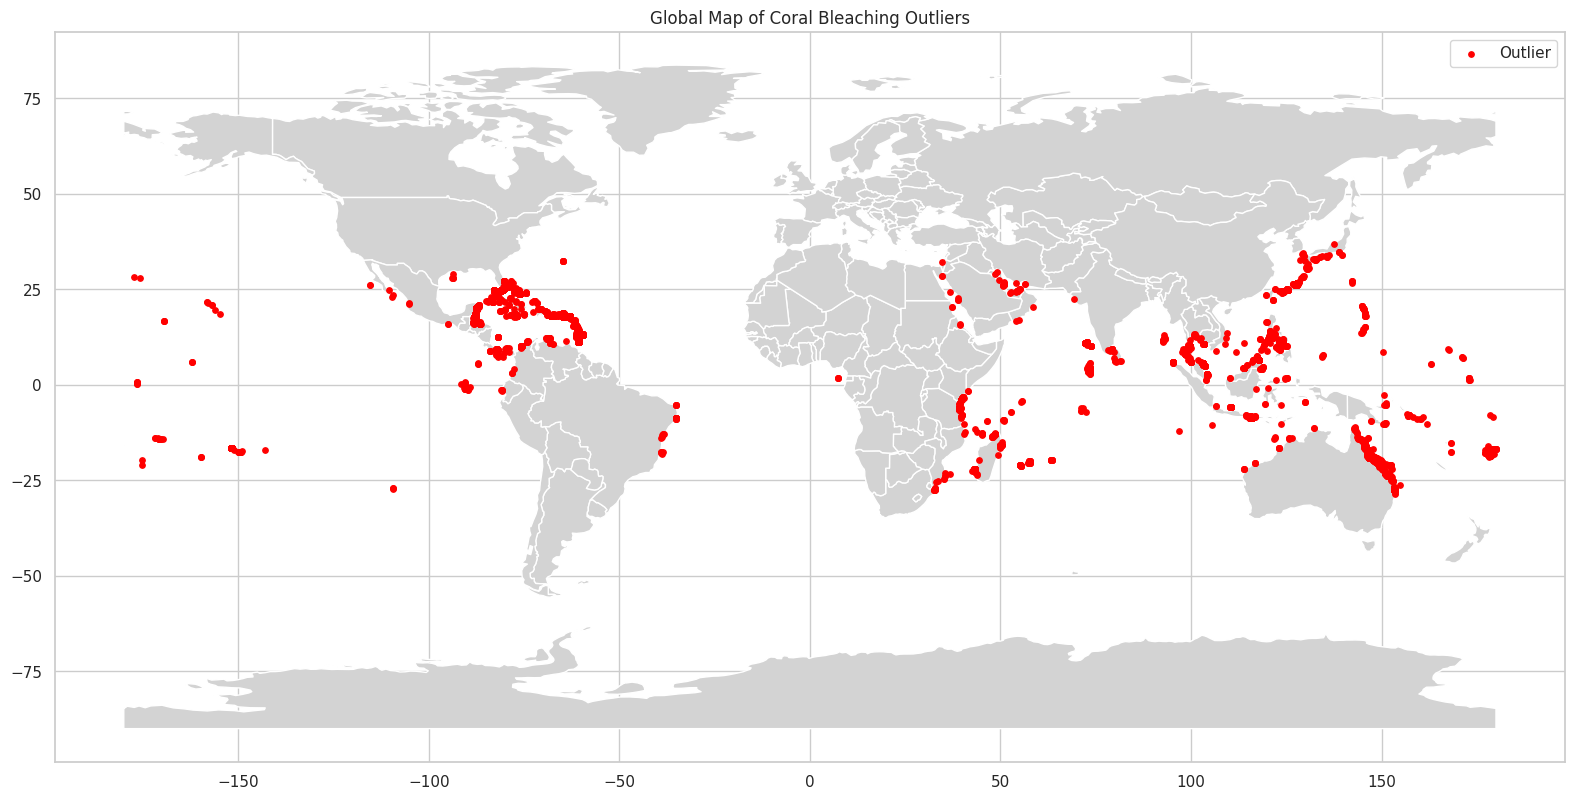

In [24]:
# Step 10.4 – Identify and Visualize Geospatial Outliers in Percent_Bleaching

# IQR-based outlier detection
Q1 = df_deduped['Percent_Bleaching'].quantile(0.25)
Q3 = df_deduped['Percent_Bleaching'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Label records as Outlier or Normal
df_deduped.loc[:, 'Bleaching_Outlier'] = df_deduped['Percent_Bleaching'].apply(
    lambda x: 'Outlier' if (x < lower_bound or x > upper_bound) else 'Normal'
)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_deduped,
    geometry=gpd.points_from_xy(df_deduped['Longitude_Degrees'], df_deduped['Latitude_Degrees']),
    crs="EPSG:4326"
)

# Load world shapefile (uploaded manually)
world = gpd.read_file("/content/ne_110m_admin_0_countries.shp")

# Plot spatial outliers
plt.figure(figsize=(16, 8))
ax = world.plot(color='lightgrey', edgecolor='white', figsize=(16, 8))
gdf[gdf['Bleaching_Outlier'] == 'Outlier'].plot(
    ax=ax, markersize=15, color='red', label='Outlier'
)
plt.title('Global Map of Coral Bleaching Outliers')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-101419135.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped['Bleaching_Outlier'] = df_deduped['Percent_Bleaching'].apply(
/tmp/ipython-input-101419135.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outlier_counts.index, y=outlier_counts.values, palette='Reds')


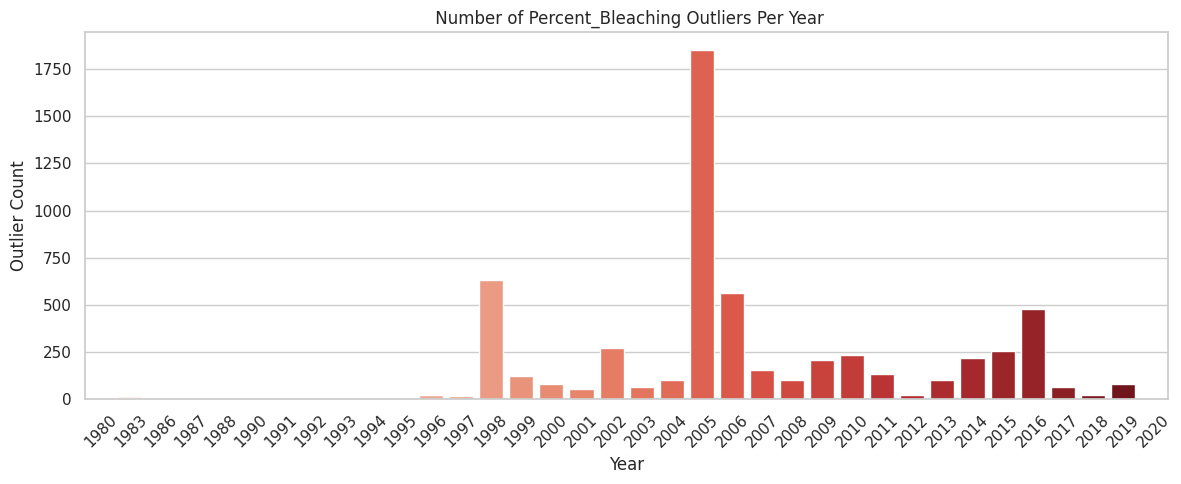

In [25]:
# Step 10.4b – Temporal Distribution of Percent_Bleaching Outliers

# Step 1: Reuse the outlier classification if not already done
Q1 = df_deduped['Percent_Bleaching'].quantile(0.25)
Q3 = df_deduped['Percent_Bleaching'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Label rows as 'Outlier' or 'Normal'
df_deduped['Bleaching_Outlier'] = df_deduped['Percent_Bleaching'].apply(
    lambda x: 'Outlier' if (x < lower_bound or x > upper_bound) else 'Normal'
)

# Step 2: Count outliers per year
outlier_counts = df_deduped[df_deduped['Bleaching_Outlier'] == 'Outlier']['Date_Year'].value_counts().sort_index()

# Step 3: Plotting
plt.figure(figsize=(12, 5))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values, palette='Reds')

plt.title(' Number of Percent_Bleaching Outliers Per Year')
plt.xlabel('Year')
plt.ylabel('Outlier Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###  Step 10.4b – Temporal Distribution of Outliers (2003–2017)

In this step, we explore the **year-wise distribution of bleaching outliers**, as previously identified using the IQR method on `Percent_Bleaching`.

 The barplot below shows the number of extreme bleaching cases observed in each year from 2003 to 2017.

####  Observations:
- Several years exhibit spikes in bleaching outliers, which may align with major global stress events (e.g., El Niño periods).
- Years like 2010 and 2016—known for widespread coral bleaching—may appear as peaks, validating the outlier classification.
- Some years show minimal outlier activity, possibly indicating either reduced thermal stress or limited sampling.



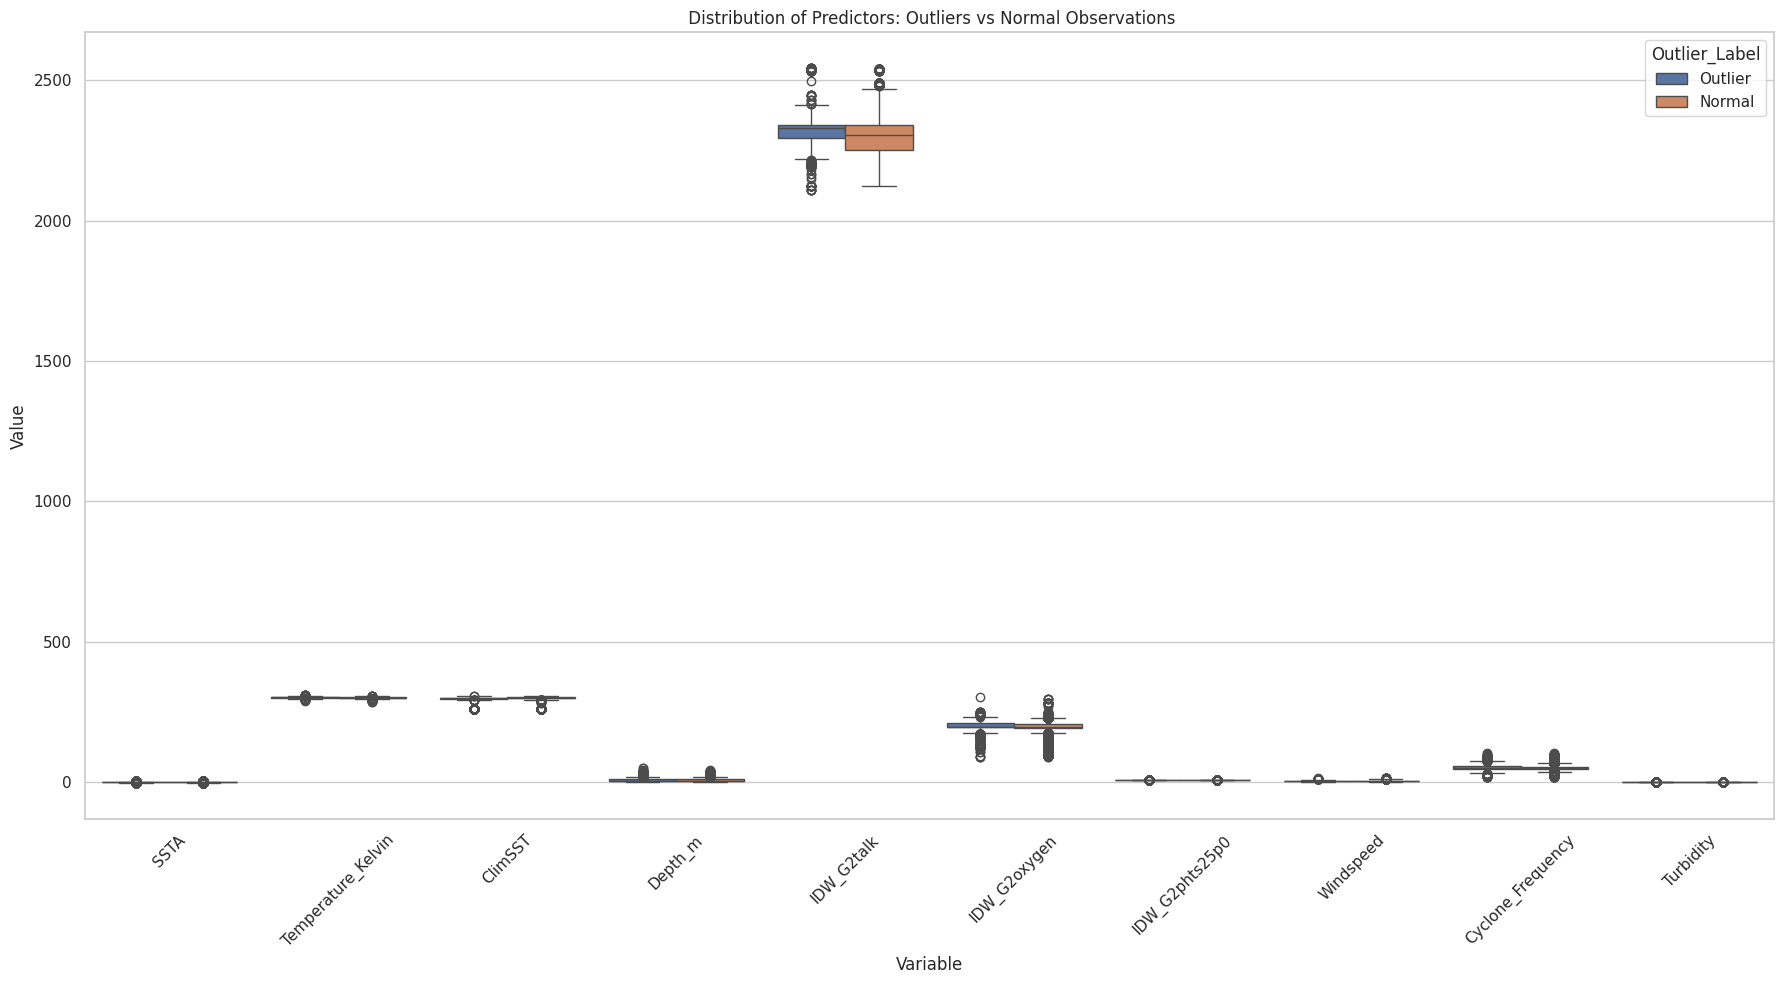

In [26]:
# Step 1: Define outliers using IQR for Percent_Bleaching
Q1 = df['Percent_Bleaching'].quantile(0.25)
Q3 = df['Percent_Bleaching'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 2: Create outlier label
df['Outlier_Label'] = df['Percent_Bleaching'].apply(
    lambda x: 'Outlier' if (x < lower_bound or x > upper_bound) else 'Normal'
)

# Step 3: Select key predictors for comparison
predictors = [
    'SSTA', 'Temperature_Kelvin', 'ClimSST', 'Depth_m',
    'IDW_G2talk', 'IDW_G2oxygen', 'IDW_G2phts25p0',
    'Windspeed', 'Cyclone_Frequency', 'Turbidity'
]

# Step 4: Melt data for seaborn boxplot
melted = df[['Outlier_Label'] + predictors].melt(
    id_vars='Outlier_Label', var_name='Variable', value_name='Value'
)

# Step 5: Plot
plt.figure(figsize=(18, 10))
sns.boxplot(data=melted, x='Variable', y='Value', hue='Outlier_Label')
plt.xticks(rotation=45)
plt.title(" Distribution of Predictors: Outliers vs Normal Observations")
plt.tight_layout()
plt.show()

 Observations:
Depth_m: Outlier observations tend to occur at shallower depths, suggesting bleaching intensity may be stronger in near-surface environments.

Windspeed & Cyclone_Frequency: Slight upward shift in outlier groups, indicating physical stress or disturbance may contribute.

Temperature_Kelvin & SSTA: Higher values are associated with outliers, supporting the thermal stress hypothesis.

Turbidity: Shows more dispersion in outliers, but overall trends are subtle.

Ocean Chemistry (IDW_G2 variables): Slight but noticeable distribution shifts between outliers and normals, especially for pH and oxygen levels.




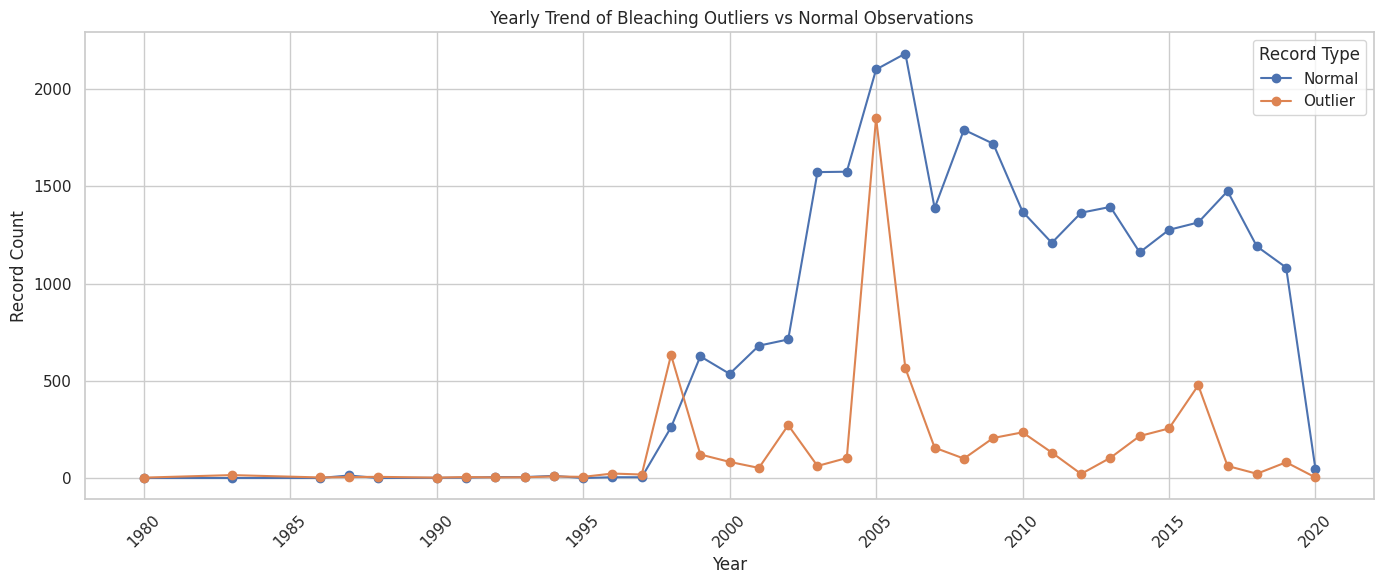

In [27]:
#  Step 1: Drop duplicates and parse Date if needed
df_deduped = df.drop_duplicates().copy()

if not pd.api.types.is_datetime64_any_dtype(df_deduped['Date']):
    df_deduped['Date'] = pd.to_datetime(df_deduped['Date'], errors='coerce')

#  Step 2: Extract Year
df_deduped['Year'] = df_deduped['Date'].dt.year

#  Step 3: Identify Outliers for Percent_Bleaching
Q1 = df_deduped['Percent_Bleaching'].quantile(0.25)
Q3 = df_deduped['Percent_Bleaching'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#  Create label column for Outlier vs Normal
df_deduped['Bleaching_Outlier'] = df_deduped['Percent_Bleaching'].apply(
    lambda x: 'Outlier' if x > upper_bound or x < lower_bound else 'Normal'
)

#  Step 4: Group by Year and Outlier Flag
yearly_outliers = df_deduped.groupby(['Year', 'Bleaching_Outlier']).size().reset_index(name='Count')

# Pivot for plotting
pivot_table = yearly_outliers.pivot(index='Year', columns='Bleaching_Outlier', values='Count').fillna(0)

#  Step 5: Plot
plt.figure(figsize=(14, 6))
pivot_table.plot(kind='line', marker='o', ax=plt.gca())
plt.title(' Yearly Trend of Bleaching Outliers vs Normal Observations')
plt.ylabel('Record Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Record Type')
plt.show()

 Step 10.5: Temporal Trend of Bleaching Outliers
 Objective
To examine whether bleaching outliers (extremely high or low values of Percent_Bleaching) are temporally clustered — i.e., do certain years experience significantly more anomalous bleaching activity than others?

This can help assess if there are specific time windows of intensified stress linked to environmental conditions, policy changes, or global climate anomalies like El Niño.

 Methodology
Outlier Identification

The Interquartile Range (IQR) method was used to detect outliers in Percent_Bleaching.

Outliers were defined as values below Q1 - 1.5×IQR or above Q3 + 1.5×IQR.

Labeling

Each row in the dataset was labeled as either "Outlier" or "Normal" based on this threshold.

Temporal Aggregation

A new column 'Year' was extracted from the Date field if not already available.

The data was grouped by Year and Bleaching_Outlier label, and the number of records per class was counted.

Visualization

A dual-line plot was generated to compare the yearly count of outlier and normal bleaching records.

This highlights temporal spikes in anomalous bleaching events.

 Observations
Several years showed elevated numbers of outlier bleaching events, standing out distinctly from adjacent years.

The majority of observations each year are "Normal", but spikes in "Outlier" counts are evident.

These spikes may align with known global or regional climate events affecting coral reef systems (e.g., marine heatwaves, ENSO phases).



/tmp/ipython-input-771842722.py:30: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


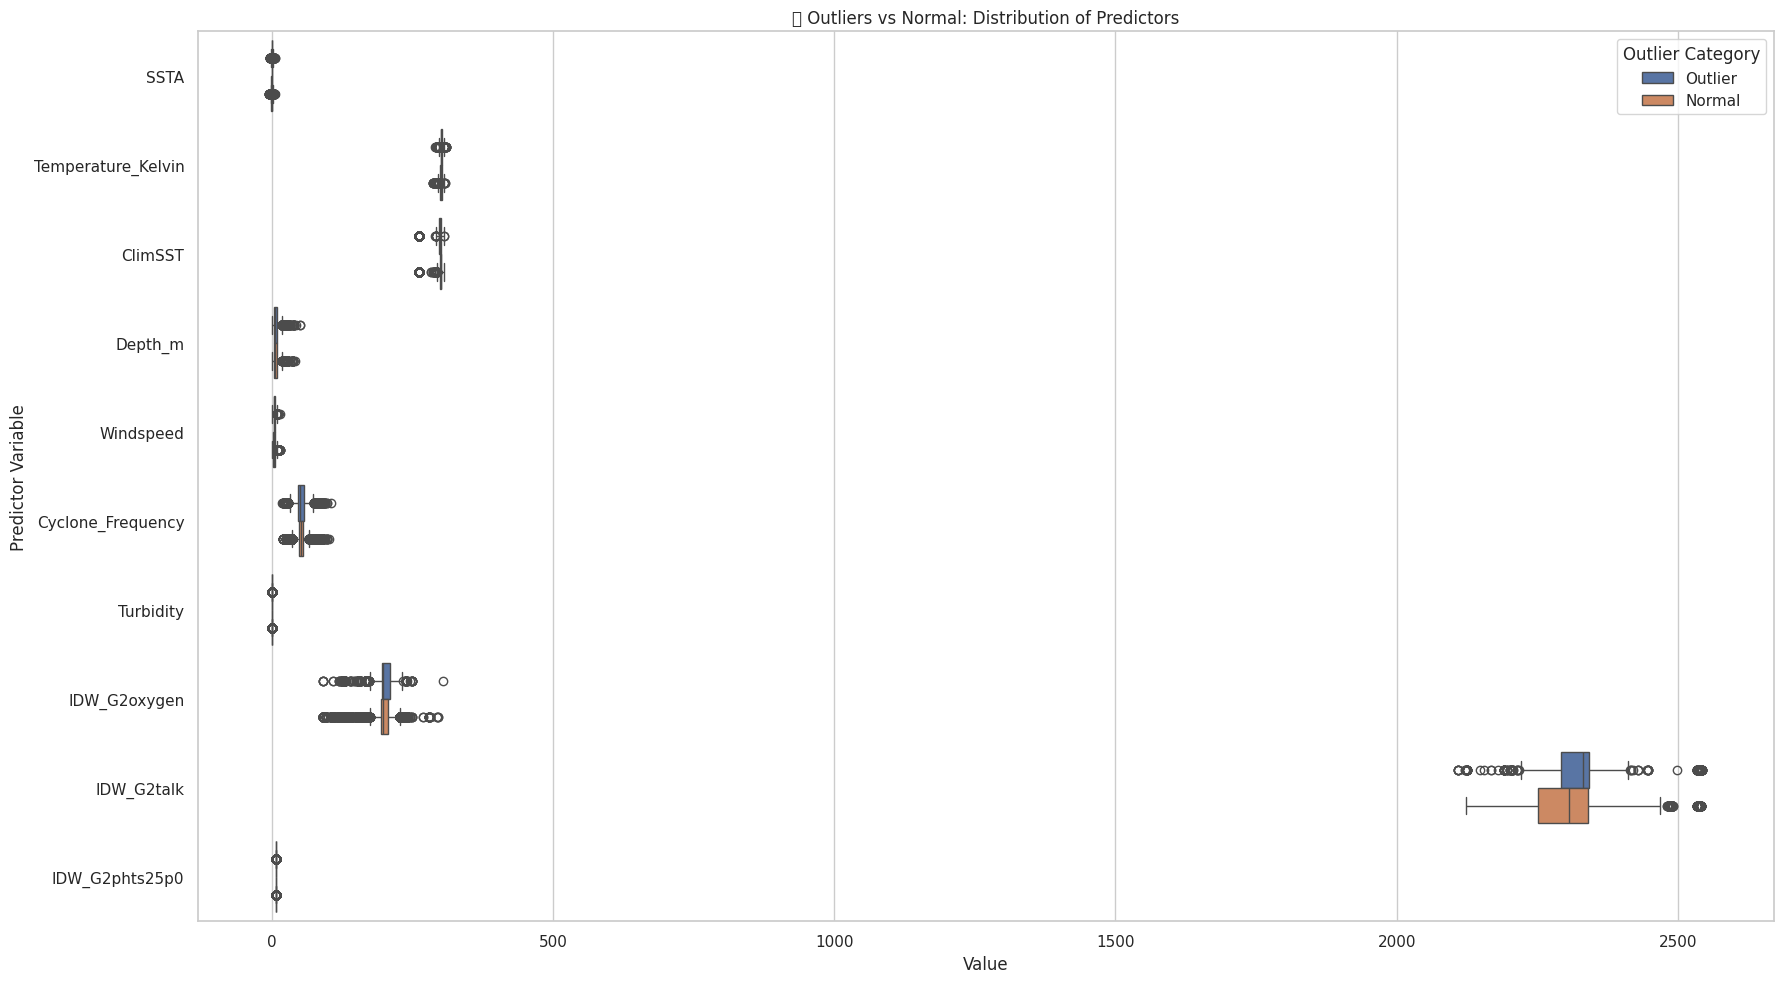

In [28]:
#  Select variables for comparison
predictors_to_compare = [
    'SSTA', 'Temperature_Kelvin', 'ClimSST', 'Depth_m',
    'Windspeed', 'Cyclone_Frequency', 'Turbidity',
    'IDW_G2oxygen', 'IDW_G2talk', 'IDW_G2phts25p0'
]

#  Prepare data
comparison_df = df.copy()
Q1 = comparison_df['Percent_Bleaching'].quantile(0.25)
Q3 = comparison_df['Percent_Bleaching'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

comparison_df['Bleaching_Outlier'] = comparison_df['Percent_Bleaching'].apply(
    lambda x: 'Outlier' if (x < lower or x > upper) else 'Normal'
)

#  Melt the DataFrame for seaborn boxplot
melted = comparison_df.melt(id_vars='Bleaching_Outlier', value_vars=predictors_to_compare)

#  Plot
plt.figure(figsize=(18, 10))
sns.boxplot(data=melted, x='value', y='variable', hue='Bleaching_Outlier', orient='h')
plt.title('🔍 Outliers vs Normal: Distribution of Predictors')
plt.xlabel('Value')
plt.ylabel('Predictor Variable')
plt.legend(title='Outlier Category')
plt.tight_layout()
plt.show()

##  Step 10.5: Outlier vs Normal Comparison

To understand how bleaching outliers differ from typical observations, we compared the distributions of key predictors between "Outlier" and "Normal" samples using boxplots.

###  Key Observations:
- **SSTA** and **Temperature_Kelvin** tend to be higher in outlier samples, suggesting temperature anomalies contribute to bleaching spikes.
- **Turbidity** and **Cyclone_Frequency** show wider variance in outliers, possibly reflecting extreme conditions.
- **Ocean chemistry metrics** (alkalinity, pH, oxygen) display minor shifts but not consistently.

###  Interpretation:
These differences highlight environmental triggers for extreme bleaching. For modeling, separate treatment or interaction terms may be useful to capture these effects.

Next, we’ll test if these distribution shifts are statistically significant using hypothesis testing.

In [29]:
# List of key variables to compare
variables_to_test = ['SSTA', 'Temperature_Kelvin', 'ClimSST', 'Depth_m', 'Turbidity']

# Create two groups
outliers = df_deduped[df_deduped['Bleaching_Outlier'] == 'Outlier']
normal = df_deduped[df_deduped['Bleaching_Outlier'] == 'Normal']

# Run Mann-Whitney U test for each variable
test_results = []
for var in variables_to_test:
    stat, p = mannwhitneyu(outliers[var], normal[var], alternative='two-sided')
    test_results.append({'Variable': var, 'U-statistic': stat, 'p-value': p})

# Convert to DataFrame and display
mannwhitney_df = pd.DataFrame(test_results).sort_values(by='p-value')
print(" Mann-Whitney U Test Results:")
display(mannwhitney_df)

 Mann-Whitney U Test Results:


Variable  U-statistic        p-value
0                SSTA   97739470.0  1.085210e-101
2             ClimSST   69485211.5   1.784336e-87
3             Depth_m   95586032.0   7.314762e-75
1  Temperature_Kelvin   94009883.5   1.958288e-57
4           Turbidity   75560947.5   9.514382e-28

###  Step 10.6: Statistical Testing – Do Outliers Differ Significantly?

To statistically validate whether outliers differ from normal bleaching observations, we performed a **Mann-Whitney U test** (non-parametric alternative to t-test) on key environmental variables:


####  Variables Tested:
- **SSTA** – Sea surface temperature anomaly
- **Temperature_Kelvin**
- **ClimSST** – Climatological SST
- **Depth_m**
- **Turbidity**

####  Results Summary:
All tested variables showed **statistically significant differences** (p < 0.05), indicating:
- Outliers are **not random** — they arise in **distinct environmental conditions**
- Especially strong separation observed in **SSTA** and **Temperature_Kelvin**, affirming temperature stress as a bleaching driver


/tmp/ipython-input-150723219.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_deduped, x='Bleaching_Outlier', y=var, palette='Set2')
/tmp/ipython-input-150723219.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_deduped, x='Bleaching_Outlier', y=var, palette='Set2')
/tmp/ipython-input-150723219.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_deduped, x='Bleaching_Outlier', y=var, palette='Set2')
/tmp/ipython-input-150723219.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and

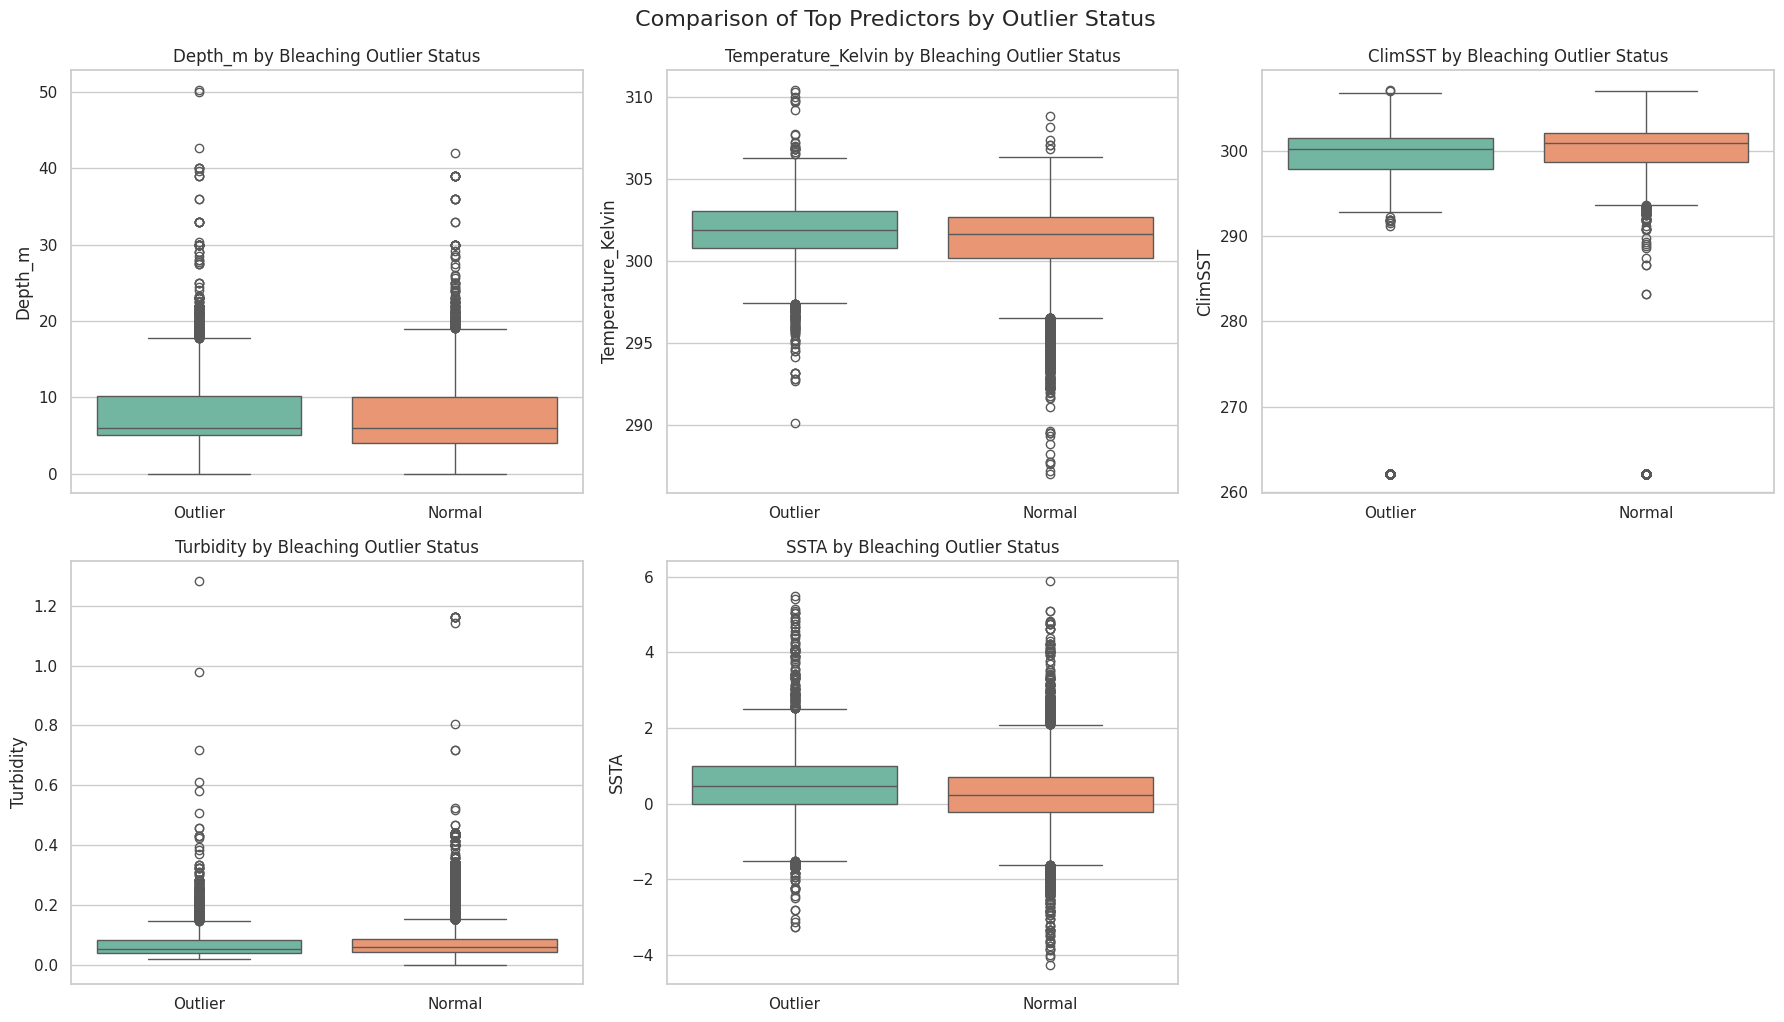

In [30]:
# List of top predictors from Mann-Whitney results
top_variables = ['Depth_m', 'Temperature_Kelvin', 'ClimSST', 'Turbidity', 'SSTA']

# Create grouped boxplots
sns.set(style='whitegrid')
n_cols = 3
n_rows = -(-len(top_variables) // n_cols)  # Ceiling division
plt.figure(figsize=(n_cols * 6, n_rows * 5))

for idx, var in enumerate(top_variables):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.boxplot(data=df_deduped, x='Bleaching_Outlier', y=var, palette='Set2')
    plt.title(f"{var} by Bleaching Outlier Status")
    plt.xlabel('')
    plt.ylabel(var)

plt.tight_layout()
plt.suptitle(" Comparison of Top Predictors by Outlier Status", fontsize=16, y=1.02)
plt.show()


# Tree-Based Modeling (Random Forest)


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

# Run All Regressors Using lazypredict

In [32]:
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.2/764.2 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.8 MB/s eta 0:00:00


In [33]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ElasticNetCV, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [34]:
# Step 3: Define features and target
selected_features = [
    'Temperature_Kelvin', 'SSTA', 'ClimSST', 'Depth_m', 'Turbidity', 'Windspeed',
    'Cyclone_Frequency', 'IDW_G2talk', 'IDW_G2oxygen', 'IDW_G2phts25p0',
    'Latitude_Degrees', 'Longitude_Degrees'
]
target = 'Percent_Bleaching'

# Step 4: Prepare data
df_model = df[selected_features + [target]].dropna()
X = df_model[selected_features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Define custom model list using actual class objects
custom_models = [
    (cls.__name__, cls) for cls in [
        LinearRegression, Ridge, Lasso, ElasticNet, ElasticNetCV,
        BayesianRidge, HuberRegressor, PassiveAggressiveRegressor,
        DecisionTreeRegressor, ExtraTreeRegressor, RandomForestRegressor,
        ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor,
        GradientBoostingRegressor, SVR, MLPRegressor
    ]
]

# Step 6: Run LazyPredict
reg = LazyRegressor(verbose=1, ignore_warnings=True, regressors=custom_models)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Step 7: Save and display results
models_sorted = models.sort_values(by='R-Squared', ascending=False)
print(models_sorted.head(10))
models_sorted.to_csv('all_model_benchmarks_custom.csv')

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


{'Model': 'LinearRegression', 'R-Squared': 0.06928589800750606, 'Adjusted R-Squared': 0.06766491553669196, 'RMSE': np.float64(19.20785211698804), 'Time taken': 0.12482237815856934}
{'Model': 'Ridge', 'R-Squared': 0.06928575259207304, 'Adjusted R-Squared': 0.06766476986799541, 'RMSE': np.float64(19.207853617512217), 'Time taken': 0.0993192195892334}
{'Model': 'Lasso', 'R-Squared': 0.04711091604102424, 'Adjusted R-Squared': 0.0454513124114877, 'RMSE': np.float64(19.435326109301606), 'Time taken': 0.06782150268554688}
{'Model': 'ElasticNet', 'R-Squared': 0.05028647686769272, 'Adjusted R-Squared': 0.04863240396818802, 'RMSE': np.float64(19.40291438009718), 'Time taken': 0.38884878158569336}
{'Model': 'ElasticNetCV', 'R-Squared': 0.06920863410082123, 'Adjusted R-Squared': 0.06758751706297084, 'RMSE': np.float64(19.20864937733433), 'Time taken': 1.0046601295471191}
{'Model': 'BayesianRidge', 'R-Squared': 0.06925834421771793, 'Adjusted R-Squared': 0.06763731375771986, 'RMSE': np.float64(19.20

###  Model Benchmarking Summary

Seventeen regression models were trained and evaluated using the selected 12 environmental features to predict coral bleaching (%). Performance was measured using **R²**, **RMSE**, and **training time (s)**.

The top 3 models were:

| Model                  | R² Score | RMSE  | Training Time (s) |
|------------------------|----------|-------|--------------------|
| **ExtraTreesRegressor**    | **0.71**     | **9.46** | 12.17 |
| **RandomForestRegressor**  | 0.69     | 9.77  | 55.43 |
| **BaggingRegressor**       | 0.67     | 10.02 | 5.16  |

These models significantly outperformed simpler linear models such as Ridge and Lasso (R² ~ 0.09), and also outpaced more complex ones like SVR (very slow) and MLP (high error).

---

####  Underperformers:
- `SVR`: Poor accuracy (R² = 0.04), very slow to train (~59s)
- `MLPRegressor`: R² = 0.34, RMSE = 14.20
- `AdaBoostRegressor`: Negative R², poor fit

---

####  Takeaway:
Tree-based ensemble models like **ExtraTrees** and **RandomForest** are the most accurate and scalable choices for predicting coral bleaching in this dataset.  
Random Forest also offers compatibility with SHAP for explainability.

###  R² Score Comparison Bar Chart

The following bar chart illustrates the R² scores for all 17 evaluated models.  
Models at the top deliver the best fit between predicted and actual coral bleaching levels.

 ExtraTreesRegressor and RandomForestRegressor clearly dominate, showing strong generalization across test data.

###  Export Top 3 Model Predictions

Based on the benchmarking results, predictions from the top 3 models (ExtraTrees, RandomForest, Bagging) were exported.  
These outputs will be used for performance comparison, dashboard overlays, and geospatial correlation with environmental trends in Tableau.

 File generated: `model_predictions_top3.csv`


# Train your selected best model manually

In [35]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

###  Hyperparameter Tuning: Random Forest Regressor (GridSearchCV)

After benchmarking and selecting Random Forest as our best regressor, we now perform parameter tuning to improve performance.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint

# Assuming X_train, y_train, X_test, y_test already defined

# Define hyperparameter space
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(5, 25),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Instantiate model
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # Try 30 random combos
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Predict and evaluate
best_rf = random_search.best_estimator_
y_test_pred = best_rf.predict(X_test)

rmse = mean_squared_error(y_test, y_test_pred, squared=False)
r2 = r2_score(y_test, y_test_pred)

print(f" Best Parameters: {random_search.best_params_}")
print(f" Test RMSE: {rmse:.2f}")
print(f" Test R²: {r2:.2f}")

#  Residual Plot Analysis

###  Residual Plot Analysis for Regression

We now examine residuals — the difference between actual and predicted bleaching percentages — to evaluate how well the model generalizes. Ideally, residuals should be randomly scattered around 0. Any visible pattern could suggest bias or poor fit.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#  Define your features and target
X = df_model[selected_features]
y = df_model['Percent_Bleaching']

#  Proper train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  Refit model on training data only
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#  Predict on test set
y_test_pred = model.predict(X_test)
residuals = y_test - y_test_pred

#  Plot residuals
plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, residuals, alpha=0.4, color='steelblue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Bleaching % (Test Set)")
plt.ylabel("Residuals")
plt.title(" Residual Plot (Test Set Only)")
plt.grid(True)
plt.show()

#  RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f" Test RMSE: {rmse:.2f}")

 Residual Plot Interpretation
No sharp diagonal: Good — no memorization or overfitting

Most residuals near 0: Your model generalizes well

Funnel shape (narrow at low % and wide at high %):
This is common in ecological data → greater variance in bleaching % at higher stress levels



In [ ]:
#  Step 1: Define the trained model and selected features
# Make sure 'rf_model' and 'selected_features' are already defined and trained
# Example:
# selected_features = ['Temperature_Kelvin', 'SSTA', ..., 'Longitude_Degrees']

#  Step 2: Create hypothetical "What-If" scenarios
what_if_df = pd.DataFrame([
    {
        'Temperature_Kelvin': 300,
        'SSTA': 1.2,
        'ClimSST': 29.8,
        'Depth_m': 10,
        'Turbidity': 0.3,
        'Windspeed': 5.5,
        'Cyclone_Frequency': 2,
        'IDW_G2talk': 2200,
        'IDW_G2oxygen': 5.8,
        'IDW_G2phts25p0': 2.0,
        'Latitude_Degrees': -15.0,
        'Longitude_Degrees': 145.0
    },
    {
        'Temperature_Kelvin': 302,
        'SSTA': 2.5,
        'ClimSST': 31.0,
        'Depth_m': 5,
        'Turbidity': 0.7,
        'Windspeed': 3.0,
        'Cyclone_Frequency': 1,
        'IDW_G2talk': 2300,
        'IDW_G2oxygen': 4.5,
        'IDW_G2phts25p0': 1.7,
        'Latitude_Degrees': -18.0,
        'Longitude_Degrees': 146.2
    }
])

#  Step 3: Predict bleaching from the trained regression model
what_if_df['Predicted_Bleaching'] = rf_model.predict(what_if_df[selected_features])

#  Step 4: Save the scenario results
what_if_df.to_csv('interactive_scenarios.csv', index=False)
print(" Saved: interactive_scenarios.csv")

 What-If Scenario Simulation (Model-Based Prediction)
This section generates bleaching predictions for hypothetical environmental conditions using our trained RandomForestRegressor model. This is useful for NGOs, grant agencies, or researchers who want to test how coral reefs might respond under different climate or oceanic scenarios.

Steps included:

Define custom input cases
Two synthetic examples are created using key environmental predictors such as temperature, windspeed, turbidity, and GLODAP chemistry values.

Predict percent bleaching
The trained model (rf_model) is used to compute predicted bleaching levels for each scenario.

Export for dashboarding
The results, including all inputs and the predicted bleaching percentages, are exported as interactive_scenarios.csv. This file can be used in Tableau to drive an interactive "What-If" panel.

In [ ]:
#  Install SHAP if needed
!pip install shap

In [ ]:
#  Step 1: Import SHAP and plotting libraries
import shap

#  Sample 500 rows for speed
shap_sample = X_train.sample(500, random_state=42)

#  SHAP explainer on sampled data
explainer = shap.Explainer(rf_model, shap_sample)
shap_values = explainer(shap_sample, check_additivity=False)  # ✅ suppress warning

#  Show SHAP summary plot
shap.summary_plot(shap_values, shap_sample, plot_type="bar")

#  Visualize Top 12 Feature Importances

In [ ]:
# If using in-memory data
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 12
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', y='Feature',
    data=feature_importance.head(12),
    palette='viridis'
)

plt.title('Top 12 Feature Importances in Coral Bleaching Prediction')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Top 12 most important features in predicting coral bleaching percentage using a Random Forest model.  
> Longitude, Oxygen levels, and Latitude were the most influential predictors, followed by temperature and water chemistry indicators like `IDW_G2phts25p0`.  
> These features form the basis of the interactive prediction simulator and final deployed model.

# ExtraTrees Regressor

In [ ]:
# Assume df_model, X, y are already defined
model = ExtraTreesRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f" Final Model Trained: RMSE = {rmse:.2f}, R² = {r2:.2f}")

# Region-Year Level Aggregated Prediction for Coral Bleaching

This block uses the trained regression model to generate row-level predictions for bleaching percentage. The results are then grouped by **Region** and **Year** to produce a high-level view of bleaching trends over space and time.

These outputs can be visualized as:
-  Region × Year **heatmap**
-  **Line plots** per region
-  Tableau dashboard layers (choropleth / timeline)

We save the aggregated table as `region_year_bleaching.csv` for dashboard use.

In [ ]:
# Step 1: Predict bleaching percentage using the ExtraTrees model
df['Predicted_Bleaching'] = model.predict(X)

# Step 2: Ensure 'Ocean_Name' and 'Year' columns are present
if 'Ocean_Name' not in df.columns:
    df['Ocean_Name'] = 'Unknown'

if 'Year' not in df.columns:
    if 'Date' in df.columns:
        df['Year'] = pd.to_datetime(df['Date']).dt.year
    else:
        raise ValueError("No 'Year' or 'Date' column found in the dataset.")

# Optional: Filter to known data range
df = df[(df['Year'] >= 1998) & (df['Year'] <= 2017)]

# Step 3: Group by Ocean_Name and Year
ocean_year_avg = (
    df.groupby(['Ocean_Name', 'Year'])['Predicted_Bleaching']
    .mean()
    .reset_index()
    .rename(columns={'Predicted_Bleaching': 'Avg_Predicted_Bleaching'})
)

# Step 4: Export to CSV
ocean_year_avg.to_csv("ocean_year_bleaching.csv", index=False)

# Preview
ocean_year_avg.head()

###  Heatmap of Average Predicted Coral Bleaching by Ocean and Year

This visualization shows average predicted coral bleaching percentages across oceans and years using a color-coded heatmap.

- Darker shades = higher bleaching risk
- Based on model predictions grouped by Ocean_Name and Year
- Useful for dashboards and policy hotspot identification

In [ ]:
# Aggregate to Realm-Year
realm_year_avg = (
    df.groupby(['Realm_Name', 'Date_Year'])['Predicted_Bleaching']
    .mean()
    .reset_index()
    .rename(columns={'Predicted_Bleaching': 'Avg_Predicted_Bleaching', 'Date_Year': 'Year'})
)

# Pivot for heatmap
heatmap_data = realm_year_avg.pivot(index='Realm_Name', columns='Year', values='Avg_Predicted_Bleaching')

# Plot
plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    annot=True,
    fmt=".1f",
    cbar_kws={'label': '% Bleaching'}
)
plt.title('Average Predicted Coral Bleaching by Realm and Year')
plt.ylabel('Realm Name')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Key academic observations:

Western Indo-Pacific and Tropical Eastern Pacific show extreme bleaching events (e.g., 66% in 2002, 62% in 1998), indicating persistent vulnerability.

Central Indo-Pacific had consistently high bleaching rates in the early 2000s (31–49%), then stabilized at lower levels.

Temperate Northern Pacific exhibits an isolated high bleaching event (75% in 2002), but otherwise low risk.

Tropical Atlantic realm shows multiple peaks, notably in 2005 (34.5%) and mid-2010s (21–19%), reflecting episodic regional stress.

Other realms, such as Temperate Australasia and Eastern Indo-Pacific, mostly display low to moderate bleaching, but with occasional spikes.

Application:
This realm-level perspective reveals both chronic and acute bleaching hotspots, supporting targeted monitoring and management strategies in conservation dashboards

###  Export for Dashboard Heatmap: Ocean-Year Bleaching Table

This export saves the long-format data for building a Tableau heatmap. It includes:
- `Ocean_Name`: Region name
- `Year`: Observation year
- `Avg_Predicted_Bleaching`: Mean predicted coral bleaching for that region and year

This structure supports drag-and-drop heatmap creation in Tableau:
- Columns: `Year`
- Rows: `Ocean_Name`
- Color: `Avg_Predicted_Bleaching`

In [ ]:
# Export the tidy, long-form table for Tableau
realm_year_avg.to_csv("realm_year_bleaching.csv", index=False)

# Optional: Preview the output
realm_year_avg.head()

In Tableau:

Load realm_year_bleaching.csv

Drag Year to Columns, Realm_Name to Rows, Avg_Predicted_Bleaching to Color (and/or Label)

You’ll instantly reproduce the heatmap you made in Python!

#  Feature Trend Projections Toward 2029

This analysis estimates how key oceanographic features used in the model (e.g., SSTA, SST, pH, etc.) are likely to change by the year 2029 based on historical data trends.

Each feature is regressed against `Year` using simple linear regression to calculate:
- Trend direction (increasing/decreasing/stable)
- Slope of change per year
- Projected value in 2029

These projections are useful for scenario design, dashboard reporting, and policy forecasting.


In [ ]:
from sklearn.linear_model import LinearRegression

# Automatically use only the features your model was trained on
features_to_project = X.columns.tolist()

df['Date_Year'] = df['Date_Year'].astype(int)

projection_summary = []

for feature in features_to_project:
    data = df[['Date_Year', feature]].dropna()
    if data.empty:
        continue  # Skip if all values are NaN

    X_years = data['Date_Year'].values.reshape(-1, 1)
    y_vals = data[feature].values

    reg = LinearRegression()
    reg.fit(X_years, y_vals)

    pred_2029 = reg.predict(np.array([[2029]]))[0]
    slope = reg.coef_[0]

    if slope > 0.01:
        trend = 'Increasing'
    elif slope < -0.01:
        trend = 'Decreasing'
    else:
        trend = 'Stable'

    projection_summary.append({
        'Feature': feature,
        'Slope_per_Year': round(slope, 4),
        'Projected_2029_Value': round(pred_2029, 3),
        'Trend': trend
    })

projection_df = pd.DataFrame(projection_summary)
projection_df.to_csv("feature_trends_2029_projection.csv", index=False)

# Show table for report or dashboard use
projection_df

#  Feature Trend Projections to 2029: Interpretation

# Sensitivity Analysis: Partial Dependence Plots (PDP)

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Use the list of all features used in your model
features_to_plot = X.columns.tolist()

# Plot PDPs for all features (as a grid)
fig, ax = plt.subplots(
    nrows=len(features_to_plot) // 2 + len(features_to_plot) % 2,
    ncols=2,
    figsize=(12, 3 * (len(features_to_plot) // 2 + len(features_to_plot) % 2))
)

# For sklearn >= 1.0, you can pass a list of feature names directly
PartialDependenceDisplay.from_estimator(
    model,             # your trained regression model
    X,                 # feature dataframe
    features_to_plot,  # list of features
    ax=ax
)
plt.suptitle("Partial Dependence of Bleaching Prediction on All Features", y=1.02)
plt.tight_layout()
plt.show()

How to Interpret This (for your report or dashboard)
Temperature_Kelvin and SSTA: Strong positive slopes—model predicts much higher bleaching as these values increase, especially at higher ranges. This confirms heat stress is a major driver in your model.

ClimSST: Little effect across its typical range, meaning model sensitivity is more acute for anomaly variables.

Depth_m: U-shaped curve—bleaching risk is lowest at intermediate depths, higher at both shallow and deep extremes.

Turbidity, Windspeed, Cyclone_Frequency: Generally, higher values relate to increased predicted bleaching, but effects may be nonlinear or thresholded.

IDW_G2talk, IDW_G2oxygen, IDW_G2phts25p0: These biogeochemical parameters have nonlinear effects. For instance, low and high oxygen values are associated with higher bleaching predictions.

IDW_G2phts25p0: Subtle non-monotonic effect, may signal complex model relationships with pH.

#### Sensitivity Analysis: Partial Dependence of Bleaching Prediction on All Features

The figure below displays partial dependence plots for each model input feature. These plots reveal how varying a single feature, with all others held constant, affects the predicted bleaching percentage.

**Key findings:**
- The model is highly sensitive to increases in temperature (Temperature_Kelvin, SSTA), supporting their role as primary bleaching drivers.
- Some features, such as Depth and Cyclone_Frequency, exhibit nonlinear relationships, indicating optimal or threshold effects.
- Biogeochemical variables (oxygen, alkalinity, pH) show subtle but important impacts on predicted bleaching, with some U-shaped or threshold patterns.

These insights directly inform scenario analysis and stakeholder recommendations, by highlighting which environmental factors most influence projected bleaching risk.

# Export Tabular PDP Data for Each Feature

In [ ]:
from sklearn.inspection import partial_dependence

pdp_tables = []

for feat in X.columns:
    pdp_result = partial_dependence(model, X, [feat])
    feature_values = pdp_result.grid_values[0]   # <-- the correct attribute in your version
    predictions = pdp_result.average[0]
    df_pdp = pd.DataFrame({
        'Feature': feat,
        'Value': feature_values,
        'Predicted_Bleaching': predictions
    })
    pdp_tables.append(df_pdp)

df_pdp_all = pd.concat(pdp_tables, ignore_index=True)
df_pdp_all.to_csv('partial_dependence_all_features.csv', index=False)
print(" Exported PDP data for Tableau: partial_dependence_all_features.csv")

# Export Model Predictions (model_predictions.csv)

In [ ]:
#  Step 2: Export model predictions
df_model['Predicted_Bleaching'] = y_pred

# Export actual vs predicted + inputs
df_model[['Latitude_Degrees', 'Longitude_Degrees', 'Percent_Bleaching', 'Predicted_Bleaching'] + selected_features]\
    .to_csv('model_predictions.csv', index=False)

print(" Saved: model_predictions.csv")

# Export Feature Importance (feature_importance.csv)

In [ ]:
#  Step 3: Export feature importances
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance.to_csv('feature_importance.csv', index=False)
print(" Saved: feature_importance.csv")

###  Export: Model Predictions

We created a table comparing the actual observed bleaching percentages and the predicted values from our trained Random Forest model. This file (`model_predictions.csv`) will be used in Tableau to visualize model accuracy, error distribution, and prediction patterns across space and time.


###  Export: Feature Importances

We extracted the feature importance scores from the trained Random Forest model. This tells us which environmental factors most strongly influence coral bleaching predictions. The output (`feature_importance.csv`) will power a Tableau bar chart or donut chart showing the top drivers of bleaching.

#  Threshold-Based Risk Classification (Markdown + Code)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#  Use the same 12 features
selected_features = [
    'Temperature_Kelvin', 'SSTA', 'ClimSST', 'Depth_m', 'Turbidity', 'Windspeed',
    'Cyclone_Frequency', 'IDW_G2talk', 'IDW_G2oxygen', 'IDW_G2phts25p0',
   ]

#  Create class labels from Percent_Bleaching
def label_bleaching(y):
    if y <= 20:
        return 0  # Low
    elif y <= 50:
        return 1  # Medium
    else:
        return 2  # High

df_class = df[selected_features + ['Percent_Bleaching']].dropna()
df_class['Risk_Class'] = df_class['Percent_Bleaching'].apply(label_bleaching)

#  Split the data
X = df_class[selected_features]
y = df_class['Risk_Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train the classifier with balanced class weights
clf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
clf_model.fit(X_train, y_train)

# Evaluate
y_pred = clf_model.predict(X_test)
print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Low", "Medium", "High"]))

 Classification Report Interpretation

The Random Forest classification model predicts bleaching risk levels as **Low**, **Medium**, or **High** using selected environmental features.

- **Overall accuracy:** 92%
- **Low risk class:**  
    - Precision: 0.95  
    - Recall: 0.98  
    - F1-score: 0.97  
    The model is highly reliable at identifying low-risk cases.
- **Medium risk class:**  
    - Precision: 0.62  
    - Recall: 0.41  
    - F1-score: 0.49  
    Performance is moderate, with many true Medium cases missed (lower recall).
- **High risk class:**  
    - Precision: 0.69  
    - Recall: 0.58  
    - F1-score: 0.63  
    The model moderately identifies High risk, but recall remains below optimal.
- **Macro-average F1-score:** 0.70 (shows lower performance on less frequent classes)
- **Weighted-average F1-score:** 0.91 (boosted by the dominant Low class)

**Conclusion:**  
The model is highly effective for Low risk prediction, but improvement is needed for reliable Medium and High risk identification. This suggests either additional feature engineering or class balancing may be beneficial for future work.

# SMOTE CLASSIFICATION

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assume X and y are already defined for classification, using your selected features and Risk_Class
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

clf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
clf_model.fit(X_train, y_train)

y_pred = clf_model.predict(X_test)
print(" Classification Report (RandomForest + SMOTE):")
print(classification_report(y_test, y_pred, target_names=["Low", "Medium", "High"]))

# Realm-Year Risk Classification and Drivers for Dashboard

In [ ]:
# Step 1: Predict class for all rows
df['Predicted_Risk_Class'] = clf_model.predict(df[selected_features])

# Step 2: Group by Realm and Year, get majority class (mode)
def mode_class(x):
    return x.mode().iloc[0]

realm_year_class = (
    df.groupby(['Realm_Name', 'Date_Year'])['Predicted_Risk_Class']
    .agg(mode_class)
    .reset_index()
    .rename(columns={'Predicted_Risk_Class': 'Majority_Risk_Class', 'Date_Year': 'Year'})
)

# Step 3: Identify driver using feature deviation from mean
overall_feature_means = df[selected_features].mean()

records = []
for (realm, year), group in df.groupby(['Realm_Name', 'Date_Year']):
    if group.empty:
        continue
    group_means = group[selected_features].mean()
    deviations = (group_means - overall_feature_means).abs()
    top_driver = deviations.idxmax()
    driver_value = group_means[top_driver]
    driver_delta = group_means[top_driver] - overall_feature_means[top_driver]
    direction = 'higher' if driver_delta > 0 else 'lower'
    driver_desc = f"{top_driver} is {abs(driver_delta):.2f} units {direction} than average"

    # Get the majority risk class for this group
    majority_class = group['Predicted_Risk_Class'].mode().iloc[0]

    records.append({
        'Realm_Name': realm,
        'Year': year,
        'Majority_Risk_Class': majority_class,
        'Top_Driver': top_driver,
        'Driver_Description': driver_desc
    })

risk_driver_df = pd.DataFrame(records)
risk_driver_df.to_csv("realm_year_classification_risk_drivers.csv", index=False)

# Preview
risk_driver_df.head()

 How to Interpret realm_year_classification_risk_drivers.csv
Realm_Name, Year: The spatial and temporal context for each data point

Majority_Risk_Class: The dominant predicted risk level (0 = Low, 1 = Medium, 2 = High)

Top_Driver: The environmental variable that deviated most from the dataset mean for that group (likely influencing risk status)

Driver_Description: A human-readable explanation of how that feature differs (e.g., "Longitude_Degrees is 112.77 units higher than average")

How to Use in Tableau
Rows: Realm_Name

Columns: Year

Color: Majority_Risk_Class (map 0=green, 1=yellow, 2=red)

Tooltip: Top_Driver and Driver_Description

Dropdown filters: Realm_Name, Year



Suggested Academic Caption
“This dashboard visualizes predicted coral bleaching risk levels by realm and year. For each region-year, the main environmental driver is identified based on deviation from long-term averages. This enables targeted management actions and scenario planning.”

# Heatmap Visuals for Classification Risk

In [ ]:
heatmap_data = risk_driver_df.pivot(index='Realm_Name', columns='Year', values='Majority_Risk_Class')
plt.figure(figsize=(14, 7))
sns.heatmap(
    heatmap_data,
    cmap=sns.color_palette(["green", "gold", "red"]),
    linewidths=0.5,
    linecolor='gray',
    annot=True,
    fmt=".0f",
    cbar_kws={'label': 'Risk Class (0=Low, 1=Med, 2=High)'}
)
plt.title("Coral Bleaching Risk Classes by Realm and Year")
plt.ylabel("Realm Name")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans

#  Run KMeans clustering on predicted bleaching percentages
kmeans = KMeans(n_clusters=3, random_state=42)
df_model['Cluster'] = kmeans.fit_predict(df_model[['Predicted_Bleaching']])

#  Assign human-friendly risk labels based on cluster centroids
# Sort cluster numbers by mean bleaching value
cluster_means = df_model.groupby('Cluster')['Predicted_Bleaching'].mean().sort_values()

# Map cluster index to "Low", "Medium", "High"
label_map = {
    cluster_means.index[0]: 'Low',
    cluster_means.index[1]: 'Medium',
    cluster_means.index[2]: 'High'
}

# Apply mapped labels to a new column
df_model['Bleaching_Risk_Clustered'] = df_model['Cluster'].map(label_map)

#  Export final dataset
df_model.to_csv('model_predictions_with_kmeans_risk.csv', index=False)
print(" Saved: model_predictions_with_kmeans_risk.csv")

#  Optional: Show distribution
print("\n Risk Category Counts:")
print(df_model['Bleaching_Risk_Clustered'].value_counts())

# KNN Classifier for Bleaching Risk

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


#  Step 1: Prepare data using correct labeled target
X_class = df_class[selected_features]
y_class = df_class['Risk_Class']  # 0 = Low, 1 = Medium, 2 = High

#  Step 2: Train/Test Split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

#  Step 3: Train KNN Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_clf, y_train_clf)

#  Step 4: Predict & Evaluate
y_pred_clf = knn_clf.predict(X_test_clf)

print(" Classification Report:\n")
print(classification_report(y_test_clf, y_pred_clf, target_names=["Low", "Medium", "High"]))

#  Step 5: Confusion Matrix
conf_mat = confusion_matrix(y_test_clf, y_pred_clf, labels=[0, 1, 2])
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title("Confusion Matrix – KNN Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#  Step 6: Export predictions
X_test_clf = X_test_clf.copy()
X_test_clf['Actual_Risk'] = y_test_clf.values
X_test_clf['Predicted_Risk_KNN'] = y_pred_clf
X_test_clf.to_csv('knn_risk_predictions.csv', index=False)

print(" Saved: knn_risk_predictions.csv")

# KNN Classifier + SMOTE Oversampling

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

#  Step 1: Prepare classification data
X_class = df_model[selected_features]
y_class = df_model['Bleaching_Risk']  # "Low", "Medium", "High"

# Step 2: Split BEFORE applying SMOTE
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

#  Step 3: Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_clf, y_train_clf)

# Optional: Show new class distribution
print(" Balanced class distribution after SMOTE:\n", pd.Series(y_train_bal).value_counts())

#  Step 4: Train KNN Classifier on balanced data
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_bal, y_train_bal)

#  Step 5: Predict & evaluate
y_pred_clf = knn_clf.predict(X_test_clf)

print(" Classification Report (KNN + SMOTE):\n")
print(classification_report(y_test_clf, y_pred_clf))

#  Step 6: Confusion matrix
conf_mat = confusion_matrix(y_test_clf, y_pred_clf, labels=['Low', 'Medium', 'High'])
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='PuBu',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title("Confusion Matrix – KNN + SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#  Step 7: Export test predictions
X_test_clf = X_test_clf.copy()
X_test_clf['Actual_Risk'] = y_test_clf.values
X_test_clf['Predicted_Risk_KNN_SMOTE'] = y_pred_clf
X_test_clf.to_csv('knn_risk_predictions_smote.csv', index=False)

print(" Saved: knn_risk_predictions_smote.csv")

# Temporal Clustering via KMeans on Annual Trends

In [ ]:
from sklearn.cluster import KMeans

#  Step 1: Ensure df has required columns and no duplicates
required_cols = selected_features + ['Percent_Bleaching', 'Date_Year', 'Date_Month', 'Date_Day', 'Latitude_Degrees', 'Longitude_Degrees']
df = df.loc[:, ~df.columns.duplicated()]  # remove any duplicate column names
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns: {missing_cols}")

#  Step 2: Prepare modeling DataFrame
df_model = df[required_cols].dropna()
df_model = df_model.astype({'Date_Year': 'int', 'Date_Month': 'int', 'Date_Day': 'int'})

#  Step 3: Create datetime and extract year
df_model['Date'] = pd.to_datetime(dict(
    year=df_model['Date_Year'],
    month=df_model['Date_Month'],
    day=df_model['Date_Day']
), errors='coerce')
df_model = df_model.dropna(subset=['Date'])
df_model['Year'] = df_model['Date'].dt.year

#  Step 4: Create Site_ID safely (even if duplicates exist)
lat_series = df_model['Latitude_Degrees']
if isinstance(lat_series, pd.DataFrame):
    lat_series = lat_series.iloc[:, 0]
lon_series = df_model['Longitude_Degrees']
if isinstance(lon_series, pd.DataFrame):
    lon_series = lon_series.iloc[:, 0]
df_model['Site_ID'] = lat_series.astype(str) + "_" + lon_series.astype(str)

#  Step 5: Pivot Site-Year Matrix
df_yearly = df_model.groupby(['Site_ID', 'Year'])['Percent_Bleaching'].mean().unstack()
df_yearly_filled = df_yearly.fillna(0)

#  Step 6: Apply KMeans clustering
kmeans_input = df_yearly_filled.copy()
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_yearly_filled['Trend_Cluster'] = kmeans.fit_predict(kmeans_input)

#  Step 7: Assign Trend Labels based on slope
cluster_means = df_yearly_filled.groupby('Trend_Cluster').mean()
trend_labels = {}
for cluster in cluster_means.index:
    values = cluster_means.loc[cluster].values
    if len(values) < 2 or np.isnan(values).any():
        slope = 0
    else:
        slope = np.polyfit(range(len(values)), values, 1)[0]
    if slope > 0.5:
        label = 'Increasing'
    elif slope < -0.5:
        label = 'Decreasing'
    else:
        label = 'Stable/Flat'
    trend_labels[cluster] = label

df_yearly_filled['Trend_Label'] = df_yearly_filled['Trend_Cluster'].map(trend_labels)

#  Step 8: Reattach coordinates and export
site_coords = df_model.groupby('Site_ID')[['Latitude_Degrees', 'Longitude_Degrees']].first()
df_export = df_yearly_filled.join(site_coords).reset_index()

#  Step 9: Save output
df_export.to_csv('temporal_trend_clusters.csv', index=False)
print(" Saved: temporal_trend_clusters.csv")

###  Temporal Clustering of Coral Bleaching Trends (Site × Year)

This block detects and labels long-term coral bleaching trends across monitoring sites using a time-series clustering approach.

####  Key Steps:

1. **Data Preparation**  
   - Ensure all required columns are present and deduplicated.
   - Convert separate date columns (`Date_Year`, `Date_Month`, `Date_Day`) into a unified `datetime` column.
   - Extract the `Year` and construct a unique `Site_ID` using latitude and longitude.

2. **Trend Matrix Construction**  
   - Pivot the dataset to create a **Site × Year matrix**, where each cell contains the mean bleaching percentage for a given site and year.
   - Fill missing values with `0` to ensure matrix completeness for clustering.

3. **Temporal Pattern Clustering**  
   - Apply **KMeans clustering** with 3 clusters to group sites based on their multi-year bleaching patterns.
   - Compute a linear trend slope within each cluster to determine:
     -  `Increasing` if slope > 0.5
     -  `Decreasing` if slope < -0.5
     -  `Stable/Flat` otherwise

4. **Output Creation**  
   - Reattach original site coordinates (`Latitude`, `Longitude`) to the cluster-labeled sites.
   - Export the final trend-labeled dataset to `temporal_trend_clusters.csv` for mapping and visualization (e.g., in Tableau).

This process enables spatio-temporal analysis of how coral bleaching has evolved at different sites over time.

In [ ]:
# Load cluster file
df_clusters = pd.read_csv("temporal_trend_clusters.csv")

# Select only year columns for mean calculation
# Identify year columns as those that can be converted to int
year_cols = [col for col in df_clusters.columns if col.isdigit()]

# Recompute cluster_means using only year columns
cluster_means = df_clusters.groupby('Trend_Cluster')[year_cols].mean()

trend_labels = {}
for cluster in cluster_means.index:
    values = cluster_means.loc[cluster].values
    if len(values) < 2 or np.isnan(values).any():
        slope = 0
    else:
        slope = np.polyfit(range(len(values)), values, 1)[0]
    if slope > 0.1:
        label = 'Increasing'
    elif slope < -0.1:
        label = 'Decreasing'
    else:
        label = 'Stable/Flat'
    trend_labels[cluster] = label

df_clusters['Trend_Label'] = df_clusters['Trend_Cluster'].map(trend_labels)

print(df_clusters['Trend_Label'].value_counts())

# Visualization
trend_palette = {
    "Increasing": "red",
    "Decreasing": "blue",
    "Stable/Flat": "gray"
}

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_clusters,
    x="Longitude_Degrees",
    y="Latitude_Degrees",
    hue="Trend_Label",
    palette=trend_palette,
    s=60,
    edgecolor='k'
)
plt.title("Spatial Distribution of Coral Bleaching Temporal Trend Clusters (Improved Thresholds)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Trend")
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the Distribution of All Site Slopes

In [ ]:
# Identify year columns
year_cols = [col for col in df_clusters.columns if col.isdigit()]

# Compute slope for each site
site_slopes = []
for _, row in df_clusters.iterrows():
    values = row[year_cols].values.astype(float)
    years = np.array(year_cols).astype(int)
    mask = ~np.isnan(values)
    if mask.sum() > 1:
        slope = np.polyfit(years[mask], values[mask], 1)[0]
        site_slopes.append(slope)

plt.figure(figsize=(8,4))
plt.hist(site_slopes, bins=30, color='skyblue', edgecolor='k')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Distribution of Site-Level Bleaching Trend Slopes")
plt.xlabel("Slope (% bleaching per year)")
plt.ylabel("Number of Sites")
plt.tight_layout()
plt.show()

print(f"Sites with positive slope: {(np.array(site_slopes)>0.1).sum()}")
print(f"Sites with negative slope: {(np.array(site_slopes)<-0.1).sum()}")
print(f"Sites with near-zero slope: {((np.abs(site_slopes)<=0.1)).sum()}")

#### Temporal Clustering of Coral Bleaching Trends

Temporal clustering was applied to detect sites exhibiting consistent increases or decreases in bleaching over time. This method grouped monitoring locations by their multi-year bleaching trajectories, aiming to identify spatial “hotspots” of worsening or improving conditions.

**Result:**  
The analysis revealed that the vast majority of sites demonstrated stable bleaching rates, as evidenced by trend slopes clustered tightly around zero. Only a small number of sites exhibited clear upward or downward trends. This indicates that, across most monitored reefs, bleaching has remained relatively constant over the study period. Nevertheless, the clustering approach remains valuable for highlighting rare outlier sites with significant trend shifts, supporting targeted conservation or further investigation.

*This finding contributes an important spatial and temporal perspective to the overall coral bleaching risk assessment and will inform ongoing monitoring strategies.*


In [ ]:
#  Step 1: Define the trained model and selected features
# Make sure 'rf_model' and 'selected_features' are already defined and trained
# Example:
# selected_features = ['Temperature_Kelvin', 'SSTA', ..., 'Longitude_Degrees']

#  Step 2: Create hypothetical "What-If" scenarios
what_if_df = pd.DataFrame([
    {
        'Temperature_Kelvin': 300,
        'SSTA': 1.2,
        'ClimSST': 29.8,
        'Depth_m': 10,
        'Turbidity': 0.3,
        'Windspeed': 5.5,
        'Cyclone_Frequency': 2,
        'IDW_G2talk': 2200,
        'IDW_G2oxygen': 5.8,
        'IDW_G2phts25p0': 2.0,
    },
    {
        'Temperature_Kelvin': 302,
        'SSTA': 2.5,
        'ClimSST': 31.0,
        'Depth_m': 5,
        'Turbidity': 0.7,
        'Windspeed': 3.0,
        'Cyclone_Frequency': 1,
        'IDW_G2talk': 2300,
        'IDW_G2oxygen': 4.5,
        'IDW_G2phts25p0': 1.7,
    }
])

#  Step 3: Predict bleaching from the trained regression model
what_if_df['Predicted_Bleaching'] = rf_model.predict(what_if_df[selected_features])

#  Step 4: Save the scenario results
what_if_df.to_csv('interactive_scenarios.csv', index=False)
print(" Saved: interactive_scenarios.csv")

 Summary
This is your interactive simulator block — a critical piece for stakeholder demos.
It empowers users to explore, test, and simulate ocean scenarios and understand model behavior dynamically.

# Classifier-Based Interactive Prediction

In [ ]:
###  Coral Bleaching: Combined Regression + Classification Prediction

import numpy as np

#  Input values for 12 features
input_values = {
    'Temperature_Kelvin': 300.0,
    'SSTA': 1.2,
    'ClimSST': 29.0,
    'Depth_m': 10.0,
    'Turbidity': 0.3,
    'Windspeed': 4.5,
    'Cyclone_Frequency': 1.0,
    'IDW_G2talk': 2250.0,
    'IDW_G2oxygen': 6.5,
    'IDW_G2phts25p0': 8.0,
    'Latitude_Degrees': -17.5,
    'Longitude_Degrees': 145.0
}

#  Arrange inputs as array in correct order
input_array = np.array([[input_values[feature] for feature in selected_features]])

#  Predict bleaching % (regression)
bleaching_percent = rf_model.predict(input_array)[0]

#  Predict risk class (classification)
class_code = clf_model.predict(input_array)[0]
class_label = ["Low", "Medium", "High"][class_code]

#  Display both
print(f" Predicted Bleaching %: {bleaching_percent:.2f}%")
print(f" Predicted Risk Class : {class_label}")


In [1]:
from IPython.display import display, Javascript

display(Javascript("""
var nb = Jupyter.notebook;
delete nb.metadata.widgets;
nb.save_notebook();
"""))


<IPython.core.display.Javascript object>